In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from dataprep.eda import plot, plot_correlation,plot_missing
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [2]:
dj=pd.read_excel('인구.xls')
dj = dj.iloc[:,:4]
dj['읍면동'].nunique()

79

In [3]:
dj = dj.iloc[:,:4]

In [4]:
dj['읍면동'].nunique()

79

In [8]:
mapping = pd.read_excel('KIKmix.20181008.xlsx')
mapping_dj = mapping.loc[mapping['시도명'] == '대전광역시',:]

In [3]:
mapping_dj['동리명'].nunique()

177

In [15]:
mapping_dj = mapping_dj.dropna(subset=['읍면동명'])

In [21]:
mapping_dj = mapping_dj[['읍면동명','동리명']].reset_index()

In [22]:
del mapping_dj['index']

## 1. 학교

In [2]:
school=pd.read_csv('대전광역시 학교.csv')

In [6]:
school.loc[school['구분'] =='유',:]['우편번호'].mean()

34697.58167330677

In [65]:
def make_new_addresss(data,col) :
    address = []
    for dong in data[col] :
        address.extend(re.findall('\(([^)]+)',dong))
    data['동리명'] = address

In [66]:
make_new_addresss(school,'주소')

In [54]:
school = school.loc[:,['구분','공/사립','address']]

In [78]:
pivot_school=pd.pivot_table(school,columns='구분',index='동리명',aggfunc=['count'],values='학교명',fill_value=0)

In [82]:
def make_new_col(data) :
    new_col = []
    for c in data.columns.levels[1] :
        new_col.append(f'{c}')
    data.columns = new_col
    data.reset_index(inplace=True)

In [83]:
make_new_col(pivot_school)

In [86]:
pivot_school.rename(columns={'고' : '고등학교','유' : '유치원','중' : '중학교','초' : '초등학교'},inplace = True)

In [91]:
total_school=pd.merge(mapping_dj,pivot_school,on='동리명',how='left').fillna(0)

In [95]:
school = total_school.groupby('읍면동명').sum().reset_index()

In [97]:
school.rename(columns={'읍면동명' : '읍면동'},inplace = True)

In [111]:
school.iloc[:,1:] = school.iloc[:,1:].astype('int64')

## 2. 도시공원

In [19]:
jgpark = pd.read_csv('대전광역시_중구_도시공원정보_20200409.csv',encoding = 'cp949')
yspark = pd.read_csv('대전광역시_유성구_도시공원정보_20190613.csv',encoding = 'cp949')
spark = pd.read_csv('대전광역시_서구_도시공원정보_20200218.csv',encoding = 'cp949')
dpark = pd.read_csv('대전광역시_동구_도시공원정보_20190923.csv',encoding = 'cp949')
ddpark = pd.read_csv('대전광역시_대덕구_도시공원정보_20190419.csv',encoding = 'cp949')

In [20]:
def split_dong(data) :
    dongs = []
    for dong in data['소재지지번주소'] :
        dongs.append(dong.split(' ')[2]) 
    data['address'] = dongs

In [21]:
split_dong(jgpark)
split_dong(yspark)
split_dong(spark)
split_dong(dpark)
split_dong(ddpark)

In [22]:
jg = pd.pivot_table(jgpark,columns=['공원구분'],index = 'address',aggfunc=['count'],values='공원명',fill_value=0)
ys = pd.pivot_table(yspark,columns=['공원구분'],index = 'address',aggfunc=['count'],values='공원명',fill_value=0)
s = pd.pivot_table(spark,columns=['공원구분'],index = 'address',aggfunc=['count'],values='공원명',fill_value=0)
dd = pd.pivot_table(ddpark,columns=['공원구분'],index = 'address',aggfunc=['count'],values='공원명',fill_value=0)
d = pd.pivot_table(dpark,columns=['공원구분'],index = 'address',aggfunc=['count'],values='공원명',fill_value=0)

In [23]:
def make_new_col(data) :
    new_col = []
    for c in data.columns.levels[1] :
        new_col.append(f'{c}')
    data.columns = new_col
    data.reset_index(inplace=True)
    data.rename(columns = {'address':'동리명'},inplace = True)

In [24]:
make_new_col(jg)
make_new_col(ys)
make_new_col(s)
make_new_col(d)
make_new_col(dd)

In [25]:
park = pd.concat([jg,ys,s,d,dd]).fillna(0).reset_index()

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [26]:
col = []
col.append(park.columns[2])
col.extend(park.columns[:2])
col.extend(park.columns[3:])

In [27]:
park = park[col]

In [28]:
park_map = pd.merge(map_dj,park,on='동리명',how='left').fillna(0)

In [29]:
park_map = park_map.groupby('읍면동명').sum().iloc[:,1:]
park_map.reset_index(inplace=True)
park_map.rename(columns={'읍면동명' : '읍면동'},inplace = True)

In [30]:
dj = pd.merge(dj,park_map)

## 3. 문화축제

In [31]:
jg = pd.read_csv('대전광역시_중구_문화축제_20200302.csv',encoding = 'cp949')
ys = pd.read_csv('대전광역시_유성구_문화축제_20200302.csv',encoding = 'cp949')
dg = pd.read_csv('대전광역시_동구_문화축제_20200224.csv',encoding = 'cp949')
dd = pd.read_csv('대전광역시_대덕구_문화축제_20190916.csv',encoding = 'cp949')

In [32]:
split_dong(jg)
split_dong(ys)
split_dong(dg)
split_dong(dd)

In [33]:
jc=pd.DataFrame(jg.groupby('address').size())
yc=pd.DataFrame(ys.groupby('address').size())
dc=pd.DataFrame(dg.groupby('address').size())
ddc=pd.DataFrame(dd.groupby('address').size())

In [34]:
festival = pd.concat([jc,yc,dc,ddc])

In [35]:
festival.reset_index(inplace=True)

In [36]:
festival.rename(columns={0:'축제횟수'},inplace=True)

In [37]:
festival.rename(columns={'address' : '동리명'},inplace = True)

In [38]:
fest_mapping = pd.merge(map_dj,festival,on='동리명',how='left').fillna(0)

In [39]:
fest_map = fest_mapping.groupby('읍면동명').sum().iloc[:,1:]
fest_map.reset_index(inplace = True)
fest_map.rename(columns={'읍면동명' : '읍면동'},inplace = True)
dj = pd.merge(dj,fest_map)

## 4. 도서관

In [40]:
jg = pd.read_csv('대전광역시_중구_도서관_20200304.csv',encoding='cp949')
ys = pd.read_csv('대전광역시_유성구_도서관_20190906.csv',encoding='cp949')
dd = pd.read_csv('대전광역시_대덕구_도서관_20190930.csv',encoding='cp949')
dg = pd.read_csv('대전광역시_동구_도서관_20200319.csv',encoding='cp949')
sg = pd.read_csv('대전광역시_서구_도서관_20191209.csv',encoding='cp949')

In [41]:
make_new_addresss(jg,'소재지도로명주소')
make_new_addresss(ys,'소재지도로명주소')
make_new_addresss(dd,'소재지도로명주소')
make_new_addresss(dg,'소재지도로명주소')
make_new_addresss(sg,'소재지도로명주소')

In [42]:
a=pd.DataFrame(jg.groupby('address')['시도명'].count())
b=pd.DataFrame(ys.groupby('address')['시도명'].count())
c=pd.DataFrame(dd.groupby('address')['시도명'].count())
d=pd.DataFrame(dg.groupby('address')['시도명'].count())
e=pd.DataFrame(sg.groupby('address')['시도명'].count())

In [43]:
library =pd.concat([a,b,c,d,e])

In [44]:
library.reset_index(inplace = True)

In [45]:
library.rename(columns={'시도명' : '도서관','address' : '동리명'},inplace = True)

In [46]:
library.rename(columns={'address' : '동리명'},inplace = True)

In [47]:
lib_mapping = pd.merge(map_dj,library,on='동리명',how='left').fillna(0)

In [48]:
lib_mapping = lib_mapping.groupby('읍면동명').sum().iloc[:,1:]

In [49]:
lib_mapping.reset_index(inplace=True)

In [50]:
lib_mapping.rename(columns={'읍면동명' : '읍면동'},inplace = True)

In [51]:
dj = pd.merge(dj,lib_mapping)

## 5. 혼잡도

In [22]:
subad = pd.read_csv('대전도시철도 역명 현황.csv',encoding = 'cp949')

In [23]:
subway = pd.read_csv('대전광역시도시철도공사_2020년01_03월_역별_수송실적.csv',encoding = 'cp949')

In [54]:
subway=pd.merge(subway.iloc[:,1:9],subad.iloc[:,1:3],on ='역명')

In [55]:
make_new_addresss(subway,'주소')

In [56]:
del subway['주소']

In [57]:
subway['승하차평균']=((subway['1월 승차'] + subway['2월 승차'] + subway['3월 승차'] - subway['1월 하차'] -subway['2월 하차'] - subway['3월 하차'])/3).round()

In [58]:
submap = pd.DataFrame(subway.groupby(['address'])['승하차평균'].mean()).reset_index()

In [59]:
submap.rename(columns={'address' : '동리명'},inplace = True)

In [60]:
subway_mapping = pd.merge(map_dj,submap,on='동리명',how='left').fillna(0)

In [61]:
subway_mapping=subway_mapping.groupby('읍면동명').sum().iloc[:,1:]
subway_mapping.reset_index(inplace=True)

In [62]:
subway_mapping.rename(columns={'읍면동명' : '읍면동'},inplace = True)

In [63]:
dj = pd.merge(dj,subway_mapping)

In [64]:
vic = []
for c in dj['승하차평균'] :
    if c != 0 :
        vic.append(1)
    else : 
        vic.append(0)

In [65]:
dj['지하철유무'] = vic

In [66]:
dj.to_csv('대전7-10.csv',encoding = 'cp949')

In [67]:
dj.head()

,시도,시군구,읍면동,코드,고-공립,고-사립,기타-공립,기타-사립,유-공립,유-사립,...,문화공원,소공원,수변공원,어린이공원,역사공원,체육공원,축제횟수,도서관,승하차평균,지하철유무
0,대전광역시,동구,중앙동,3011051500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3869.0,1
1,대전광역시,동구,효동,3011053000,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0
2,대전광역시,동구,신인동,3011054500,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,대전광역시,동구,판암1동,3011055100,0.0,0.0,0.0,0.0,2.0,5.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,8844.5,1
4,대전광역시,동구,판암2동,3011055200,0.0,0.0,0.0,0.0,2.0,4.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,8844.5,1


## 6. 콜택시

In [2]:
call_taxi_dj01 = pd.read_csv('CALL_TAXI2_TJ_01MONTH.csv')
call_taxi_dj02 = pd.read_csv('CALL_TAXI2_TJ_02MONTH.csv')
call_taxi_dj03 = pd.read_csv('CALL_TAXI2_TJ_03MONTH.csv')
call_taxi_dj04 = pd.read_csv('CALL_TAXI2_TJ_04MONTH.csv')
call_taxi_dj05 = pd.read_csv('CALL_TAXI2_TJ_05MONTH.csv')
call_taxi_dj06 = pd.read_csv('CALL_TAXI2_TJ_06MONTH.csv')
call_taxi_dj07 = pd.read_csv('CALL_TAXI2_TJ_07MONTH.csv')
call_taxi_dj08 = pd.read_csv('CALL_TAXI2_TJ_08MONTH.csv')
call_taxi_dj09 = pd.read_csv('CALL_TAXI2_TJ_09MONTH.csv')

In [3]:
calltaxi = pd.concat([call_taxi_dj01,call_taxi_dj02,call_taxi_dj03,call_taxi_dj04,call_taxi_dj05,call_taxi_dj06,call_taxi_dj07,call_taxi_dj08,call_taxi_dj09])

In [4]:
calltaxi.reset_index(inplace = True)

In [5]:
del calltaxi['index']

Text(0.5, 1.0, '구별 콜택시 현황')

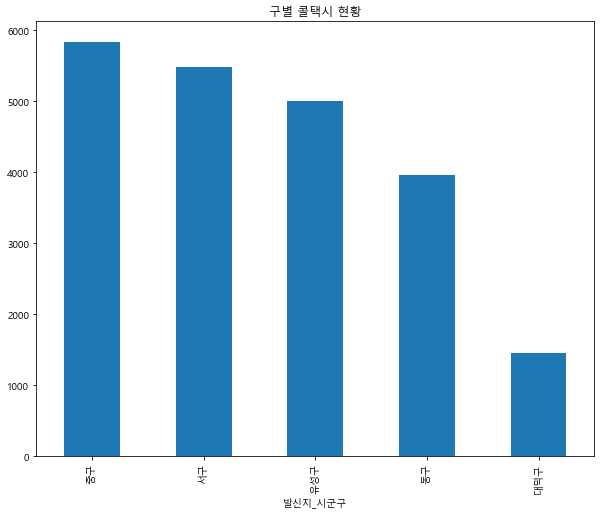

In [26]:
calltaxi.loc[calltaxi['시간대']==23,:].groupby('발신지_시군구')['통화건수'].sum().sort_values(ascending = False).plot.bar(figsize=(10,8))
plt.title('구별 콜택시 현황')

In [6]:
def night_extraction(data) :
    call_time = []
    time = []
    for c in data['시간대'].unique():
        if not 5 < c < 23 :
            call_time.append(c)
    for t in call_time :
        time.extend(list(data.index[data['시간대'] == t]))
    data = data.iloc[time,:]
    data.reset_index(inplace = True)
    del data['index']
    return data

In [7]:
night_call = night_extraction(calltaxi)

In [14]:
night_call.loc[night_call['발신지_읍면동']=='갑동',:]

,기준년월일,요일,시간대,발신지_시도,발신지_시군구,발신지_읍면동,통화건수
1716,20190624,월,0,대전광역시,유성구,갑동,5
4756,20190915,일,1,대전광역시,유성구,갑동,5
6526,20190714,일,2,대전광역시,유성구,갑동,5
8795,20190721,일,3,대전광역시,유성구,갑동,5
13168,20190508,수,5,대전광역시,유성구,갑동,5


In [552]:
def day_extraction(data) :
    call_time = []
    time = []
    for c in data['시간대'].unique():
        if  5 < c < 23 :
            call_time.append(c)
    for t in call_time :
        time.extend(list(data.index[data['시간대'] == t]))
    data = data.iloc[time,:]
    data.reset_index(inplace = True)
    del data['index']
    return data

In [554]:
day_call = day_extraction(calltaxi)

In [577]:
def make_pivot_new_col(data,a) :
    b = pd.pivot_table(data,index = '발신지_읍면동',aggfunc=['mean'],values= '통화건수',fill_value=0)
    b.columns = [a]    
    b.reset_index(inplace = True)
    b.rename(columns = {'발신지_읍면동' : '동리명'},inplace = True)
    return b

In [579]:
day_call_mean = make_pivot_new_col(day_call,'주간콜택시')

In [580]:
night_call_mean = make_pivot_new_col(night_call,'야간콜택시')

In [590]:
total_call = pd.merge(day_call_mean,night_call_mean,how='outer').fillna(0)

In [594]:
total_call.iloc[:,1:] = total_call.iloc[:,1:].round(2)

In [599]:
total_taxi = pd.merge(map_dj,total_call,how='outer').fillna(0)

In [604]:
total_taxi = total_taxi.groupby('읍면동명')[['주간콜택시','야간콜택시']].mean().round(2).reset_index()

In [610]:
total_taxi.rename(columns={'읍면동명' :'읍면동'},inplace = True)

## 7 유동인구

In [217]:
people=pd.read_excel('대전 유동인구.xlsx')

In [218]:
col = []
for a in people.columns :
    col.append(a.strip())
people.columns = col

In [439]:
people.head()

,연월,시,구,행정동,시간대,남10대 미만,남10대,남20대,남30대,남40대,...,남60대,남70대 이상,여10대 미만,여10대,여20대,여30대,여40대,여50대,여60대,여70대 이상
0,201901,대전광역시,동구,중앙동,0,138,2518,18576,13751,16533,...,22268,3532,41,1789,11443,6761,5113,7125,2815,1052
1,201901,대전광역시,동구,중앙동,1,140,1786,11463,7785,8670,...,10848,1387,37,783,5409,3611,2838,4122,1850,658
2,201901,대전광역시,동구,중앙동,2,129,1195,7579,5499,5567,...,6307,916,25,555,3044,2421,1926,2578,1375,384
3,201901,대전광역시,동구,중앙동,3,117,915,5826,4234,4741,...,5243,908,21,436,2250,1870,1574,2041,1292,415
4,201901,대전광역시,동구,중앙동,4,123,942,4867,4088,5934,...,6633,1332,22,443,1936,1709,1605,2484,2163,496


In [5]:
plot(people)

In [6]:
plot(people,'시간대','남10대 미만')

In [7]:
plot_correlation(people)

In [8]:
people.head()

,연월,시,구,행정동,시간대,남10대 미만,남10대,남20대,남30대,남40대,남50대,남60대,남70대 이상,여10대 미만,여10대,여20대,여30대,여40대,여50대,여60대,여70대 이상
0,201901,대전광역시,동구,중앙동,0,138,2518,18576,13751,16533,26904,22268,3532,41,1789,11443,6761,5113,7125,2815,1052
1,201901,대전광역시,동구,중앙동,1,140,1786,11463,7785,8670,13615,10848,1387,37,783,5409,3611,2838,4122,1850,658
2,201901,대전광역시,동구,중앙동,2,129,1195,7579,5499,5567,7951,6307,916,25,555,3044,2421,1926,2578,1375,384
3,201901,대전광역시,동구,중앙동,3,117,915,5826,4234,4741,6482,5243,908,21,436,2250,1870,1574,2041,1292,415
4,201901,대전광역시,동구,중앙동,4,123,942,4867,4088,5934,7366,6633,1332,22,443,1936,1709,1605,2484,2163,496


In [510]:
def young_extraction(data,a,b) :
    young = []
    for col in data.columns :
        if '20' in col :
            young.append(col)
    data[a] = data[young].mean(axis = 1)

In [ ]:
def old_extraction(data,a,b) :
    old = []
    for col in data.columns :
        if col.isalpha() == False :
            if int(re.findall('\d+',col)[0]) >= 60 :
                old.append(col)
    data[a] = data[old].mean(axis = 1)

### 주간유동

In [451]:
day_people=people.loc[(people['시간대']>=6) & (people['시간대'] <=22),:]

In [511]:
young_extraction(day_people,'20대평균주간유동인구','행정동')

In [505]:
old_extraction(day_people,'고령평균주간유동인구','행정동')

In [519]:
day = day_people.groupby('행정동')[['고령평균주간유동인구','20대평균주간유동인구']].mean().round(0).astype('int64').reset_index().rename(columns = {'행정동' : '읍면동'})

### 야간유동

In [ ]:
night_people=people.loc[(people['시간대'] < 6)| (people['시간대'] ==23),:]

In [527]:
young_extraction(night_people,'20대평균야간유동인구','행정동')
old_extraction(night_people,'고령평균야간유동인구','행정동')

In [528]:
night = night_people.groupby('행정동')[['고령평균야간유동인구','20대평균야간유동인구']].mean().round(0).astype('int64').reset_index().rename(columns = {'행정동' : '읍면동'})

In [531]:
total_traffic = pd.merge(night,day)

## 8 카드 매출액

In [2]:
card = pd.read_excel('대전 카드매출액.xlsx')

In [3]:
card.rename(columns={'행정동' :'읍면동'},inplace = True)

In [4]:
def card_plot_dong(data) :
    for i in data['행정동'].unique():
        data.loc[data['행정동'] == i,:].groupby('분류').mean().iloc[:,1:].plot.bar(title = '{}의 분류별 매출액'.format(i))

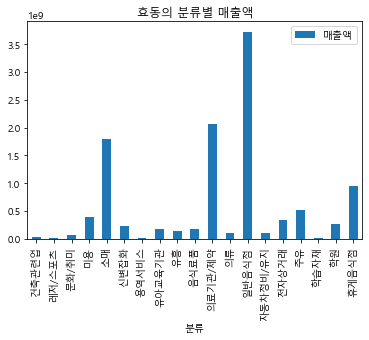

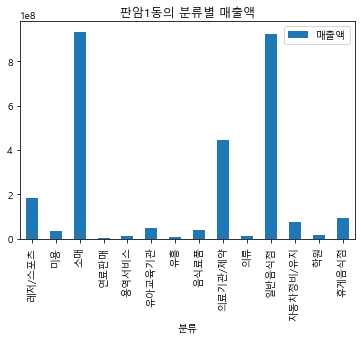

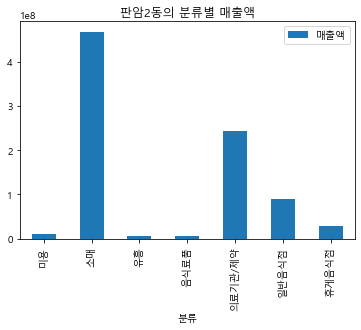

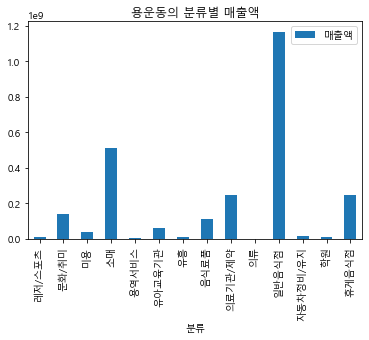

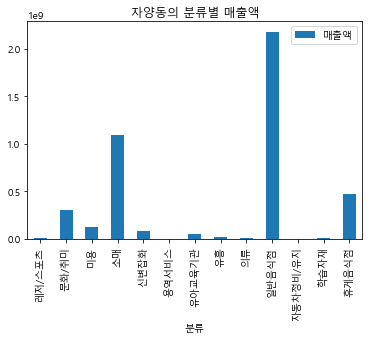

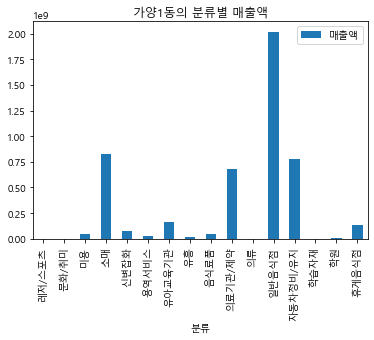

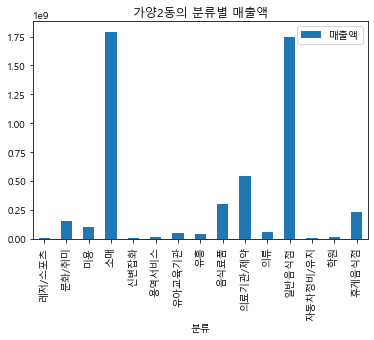

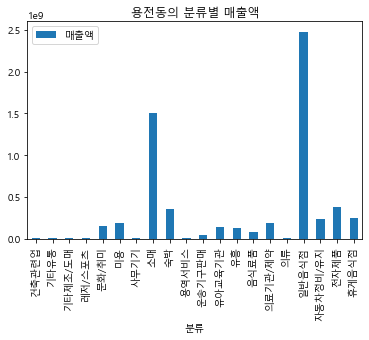

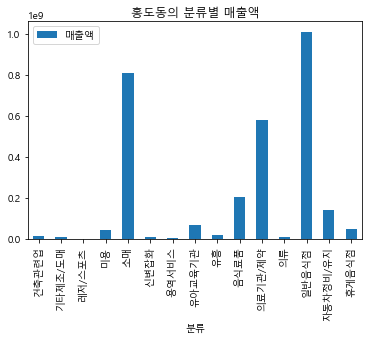

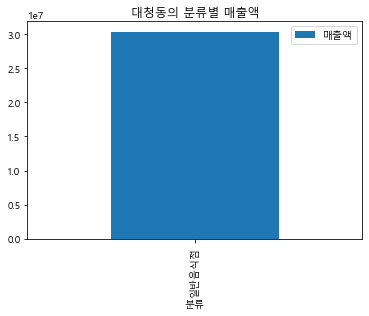

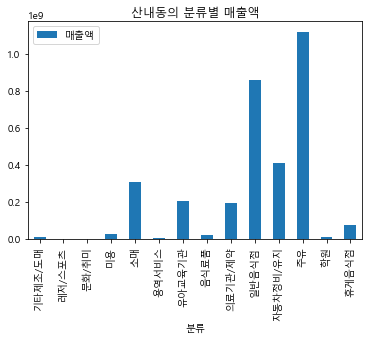

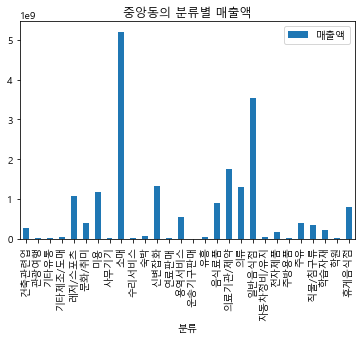

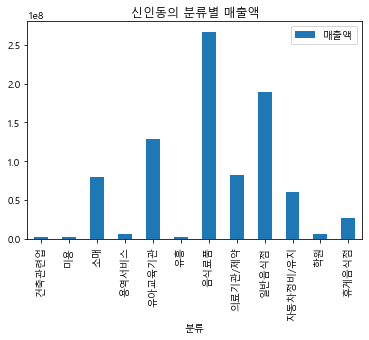

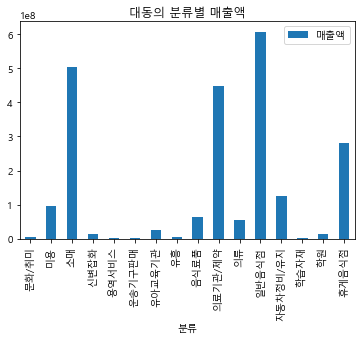

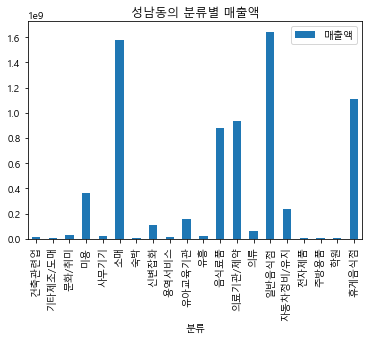

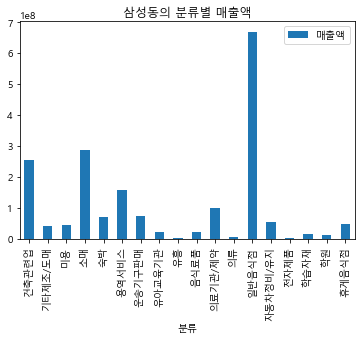

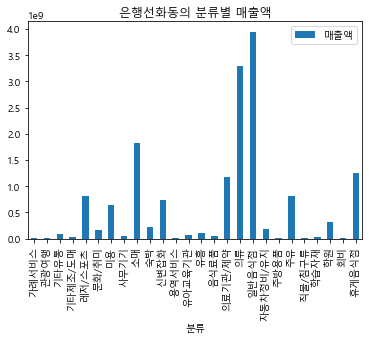

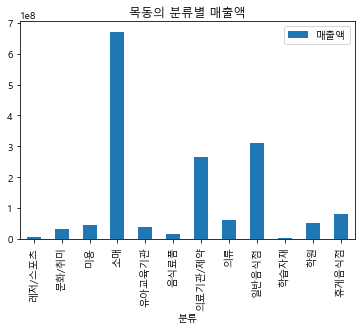

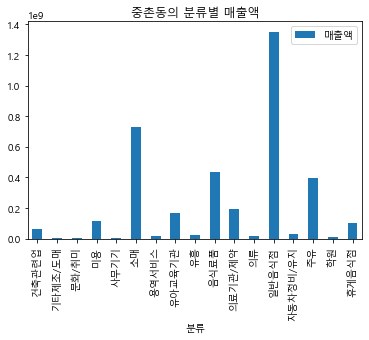

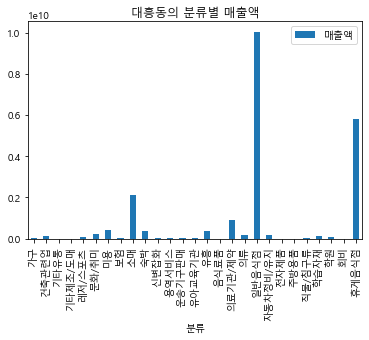

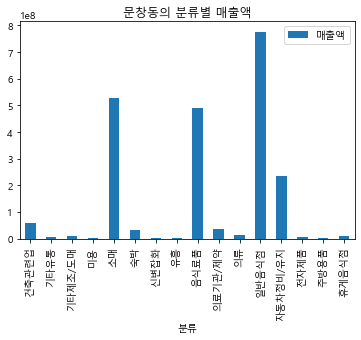

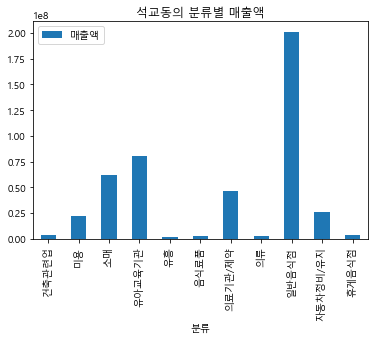

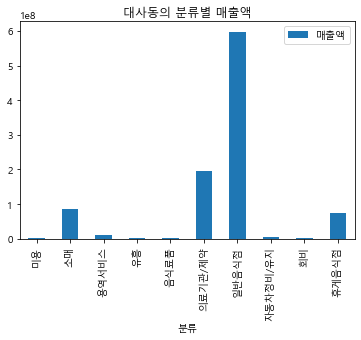

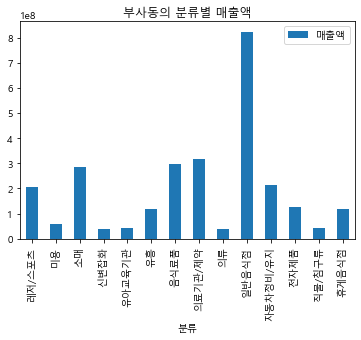

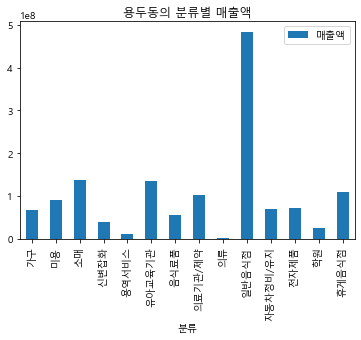

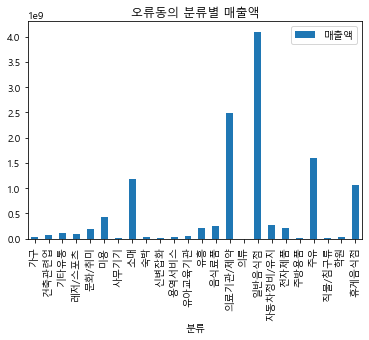

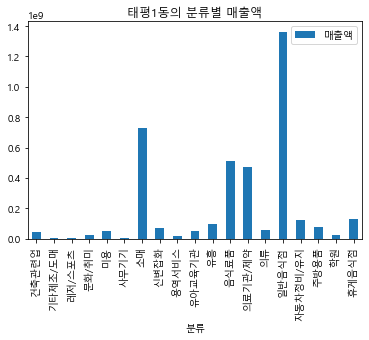

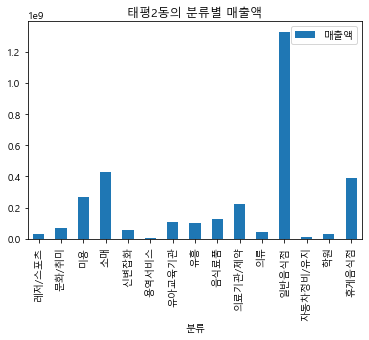

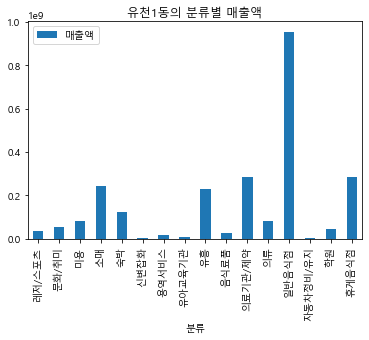

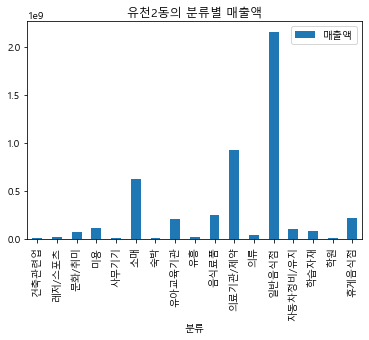

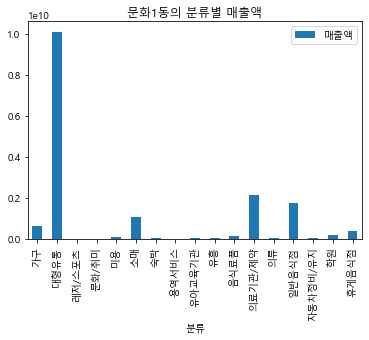

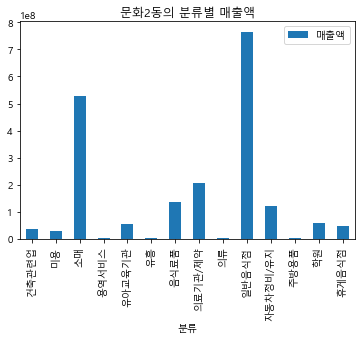

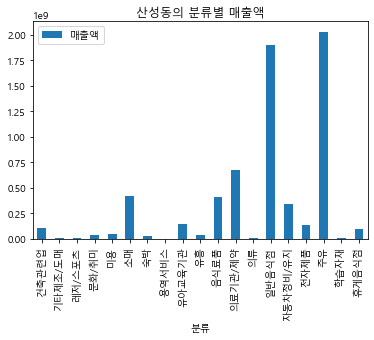

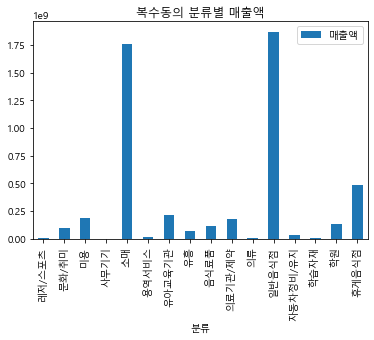

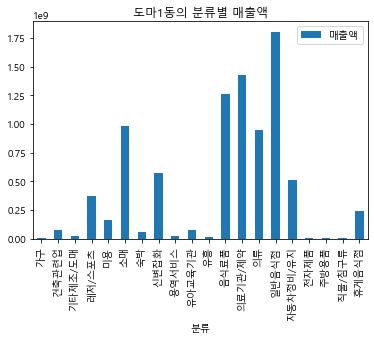

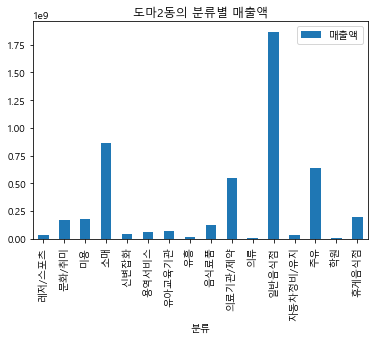

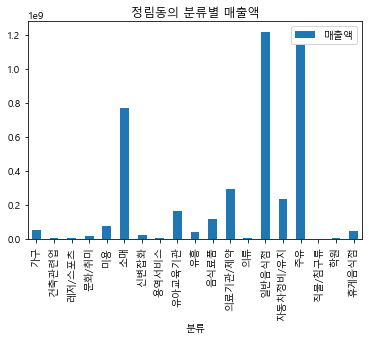

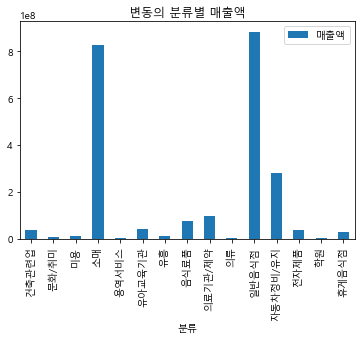

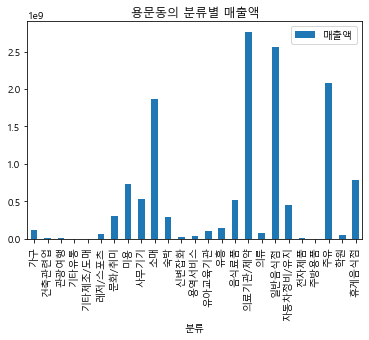

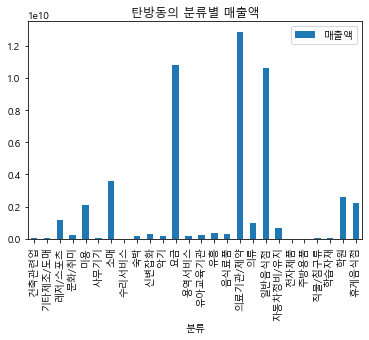

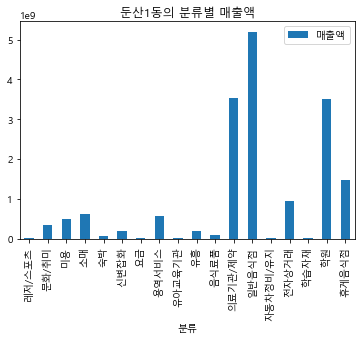

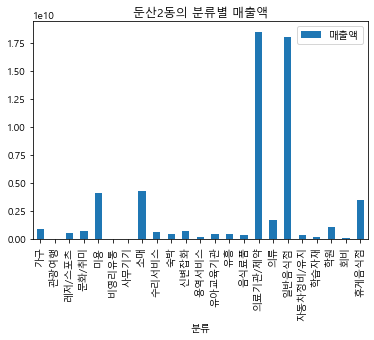

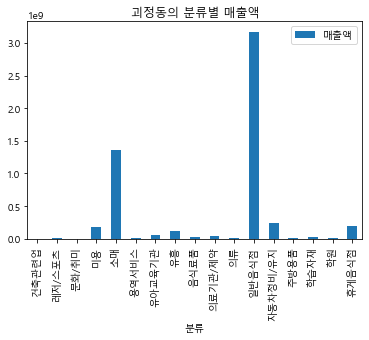

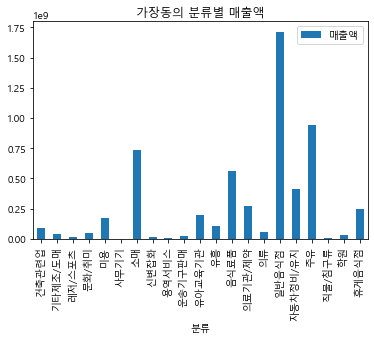

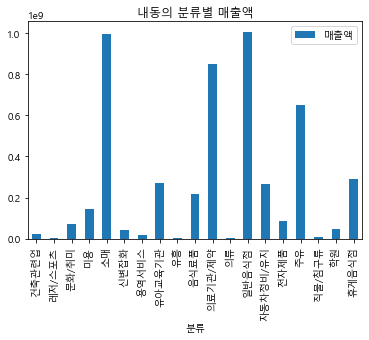

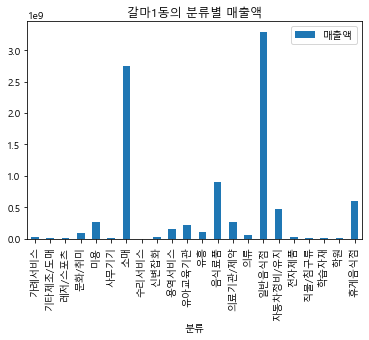

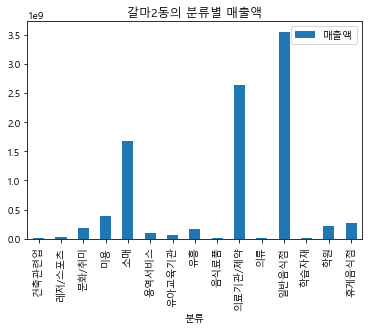

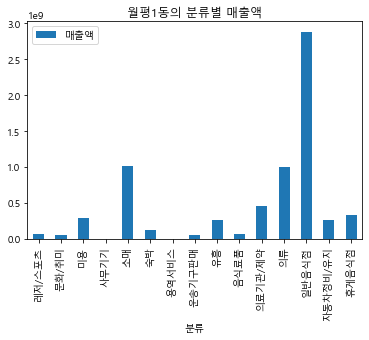

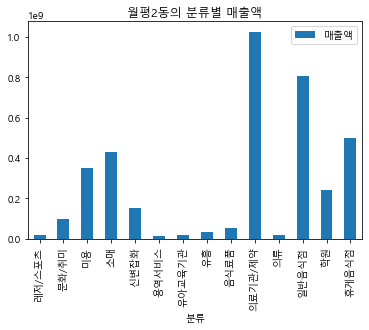

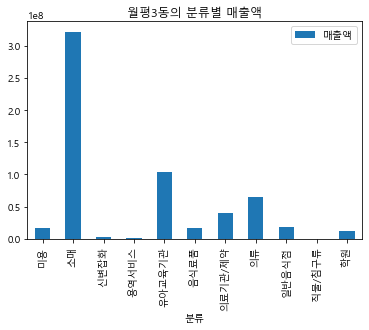

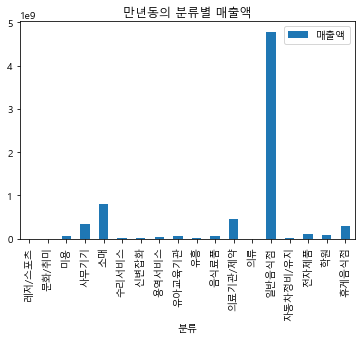

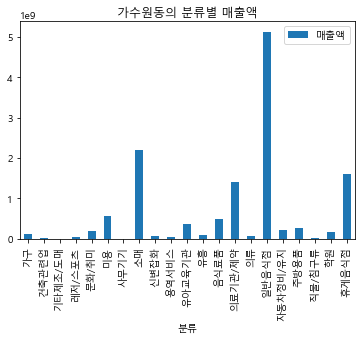

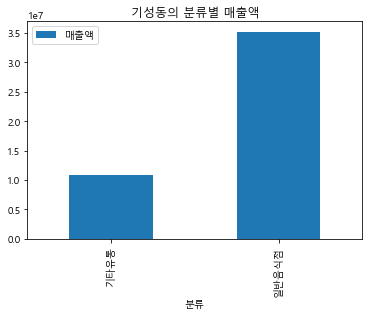

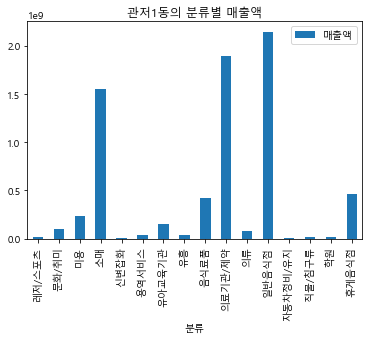

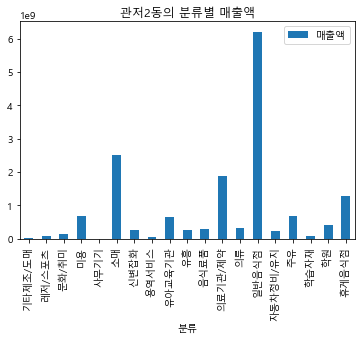

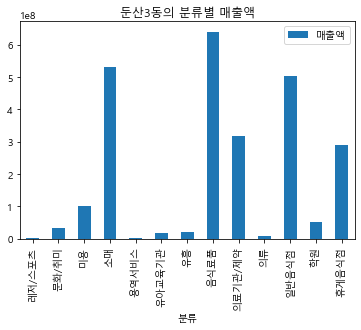

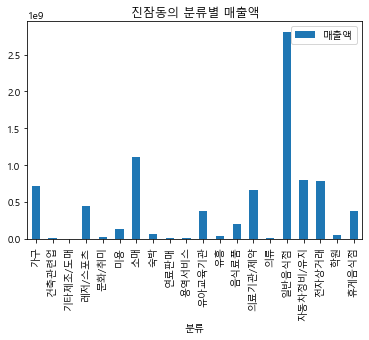

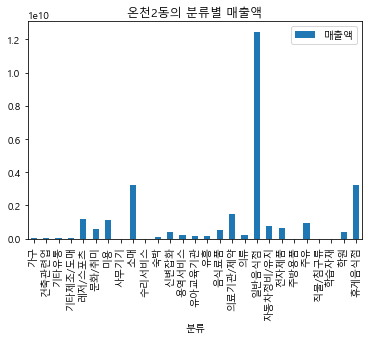

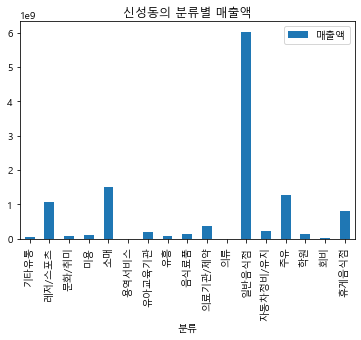

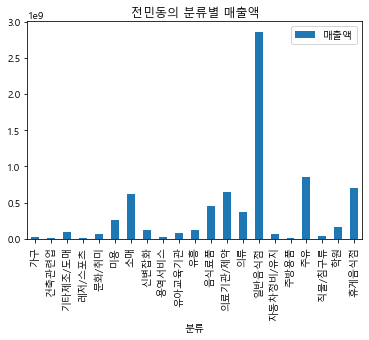

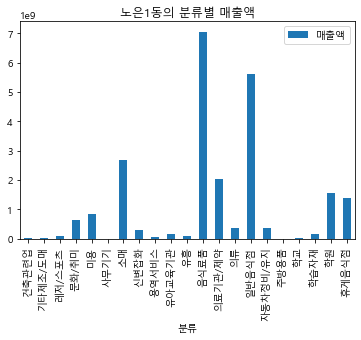

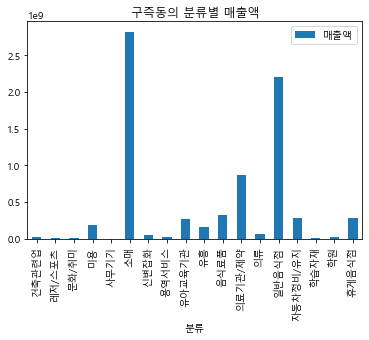

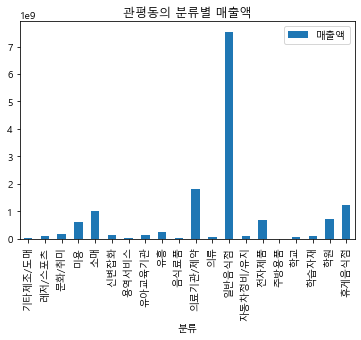

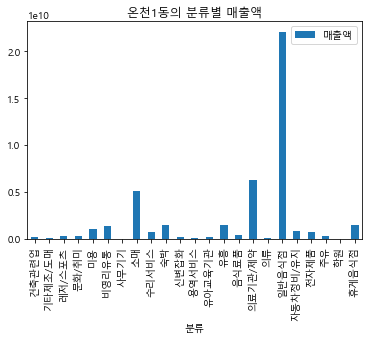

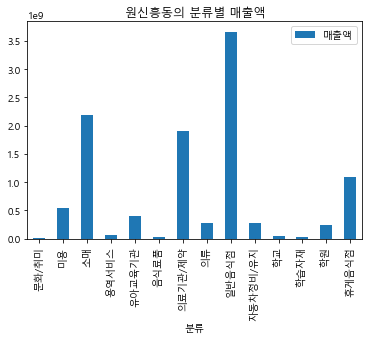

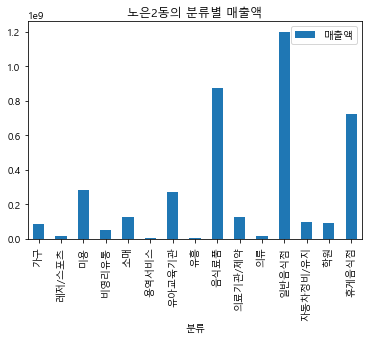

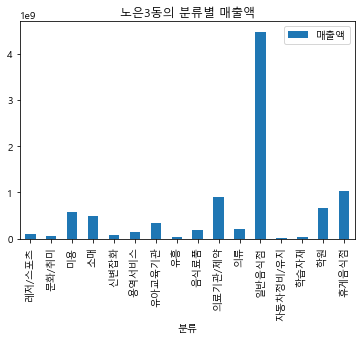

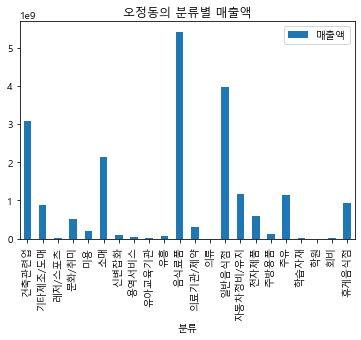

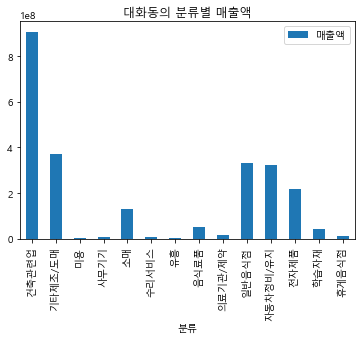

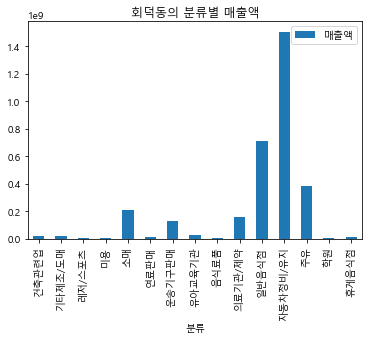

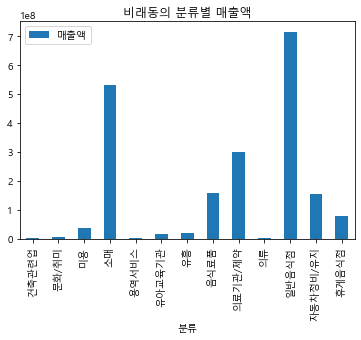

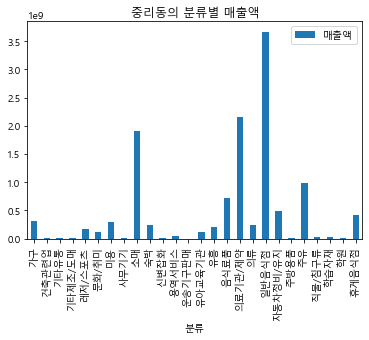

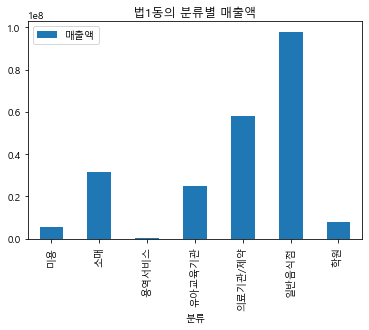

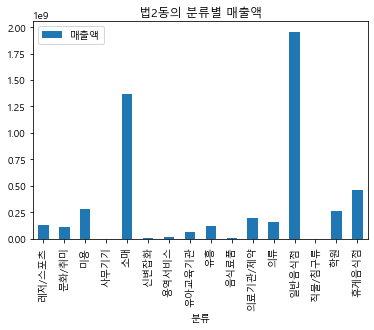

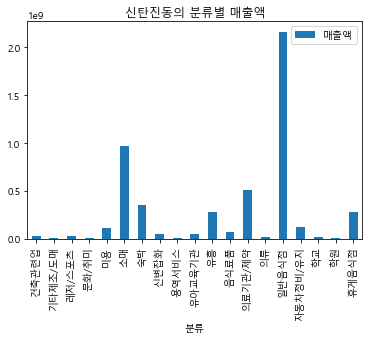

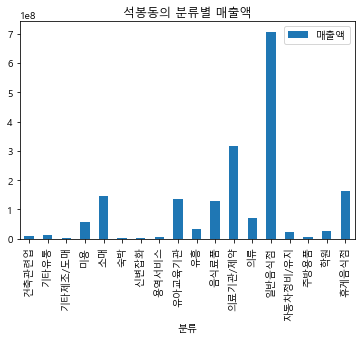

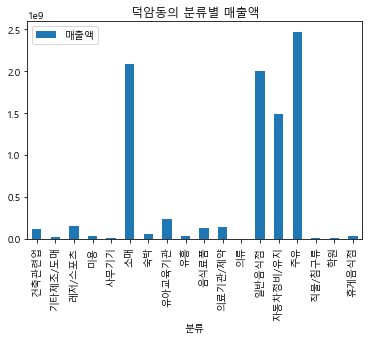

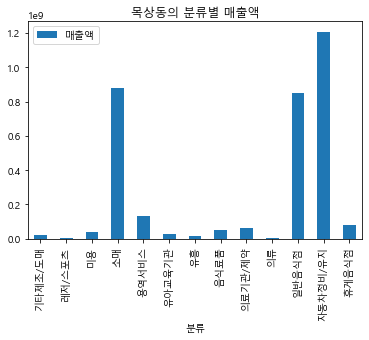

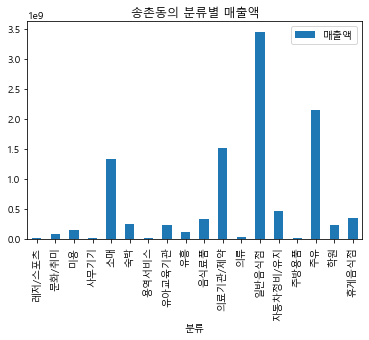

In [158]:
card_plot_dong(card)

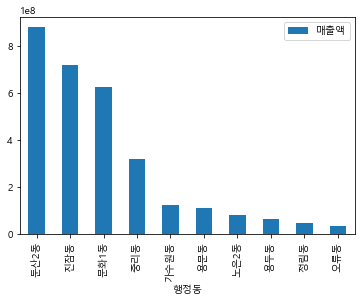

In [210]:
card.loc[card['분류']=='가구',:].groupby('행정동').mean().iloc[:,1:].sort_values(by='매출액',ascending = False)[:10].plot.bar()

In [211]:
def card_plot_classification(data) :
    for i in data['분류'].unique() :
        data.loc[data['분류'] == i,:].groupby('행정동').mean().iloc[:,1:].sort_values(by='매출액',ascending = False)[:10].plot.bar(figsize=(12,8),title= '{}별 동 top10'.format(i))

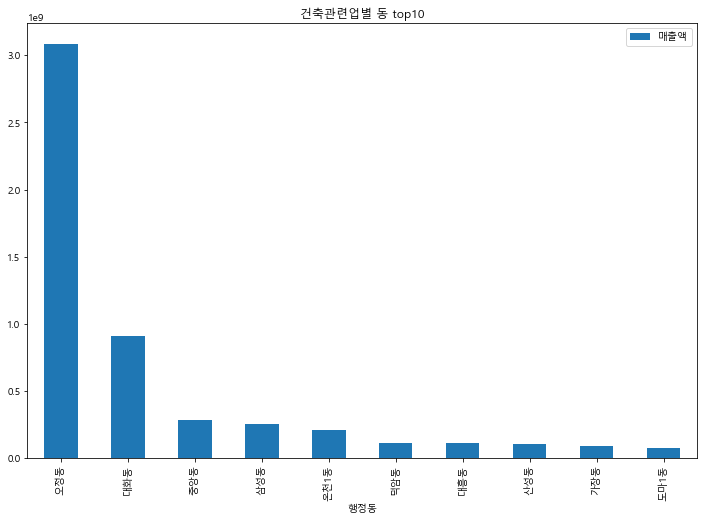

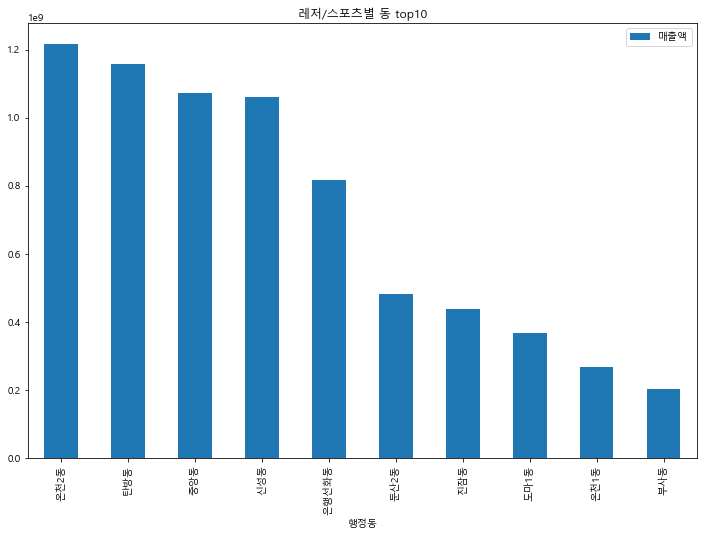

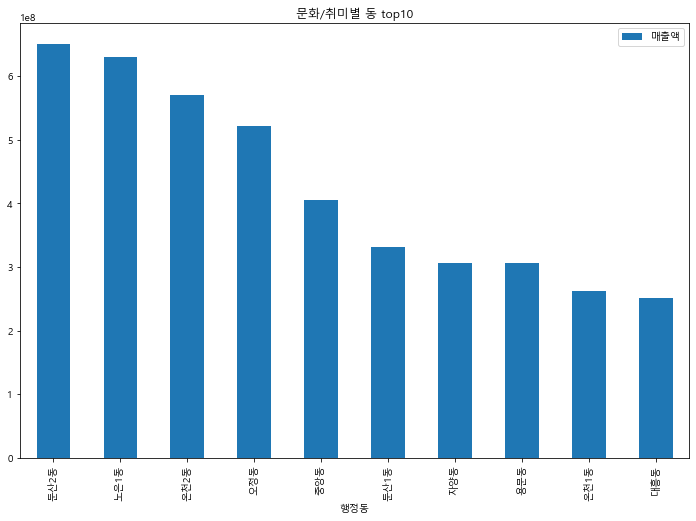

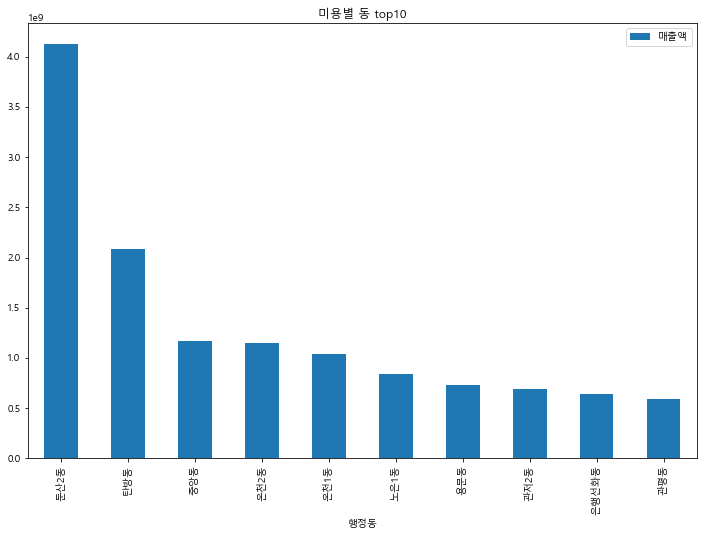

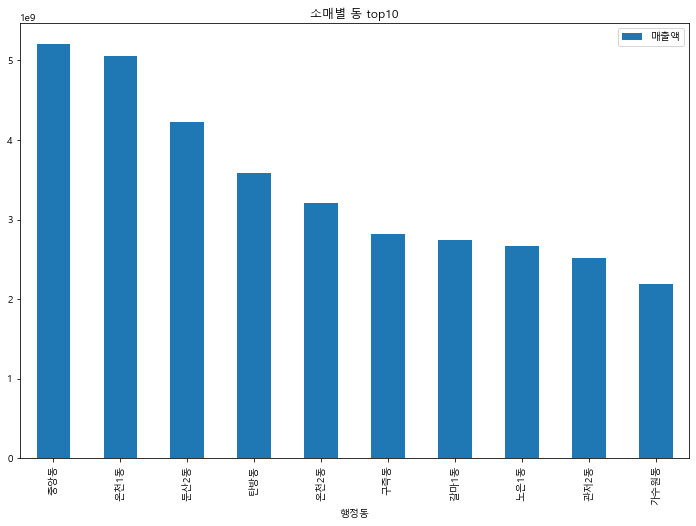

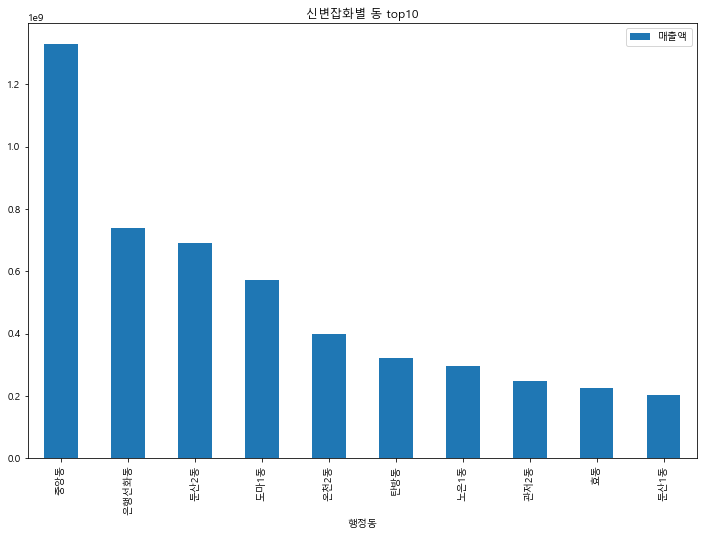

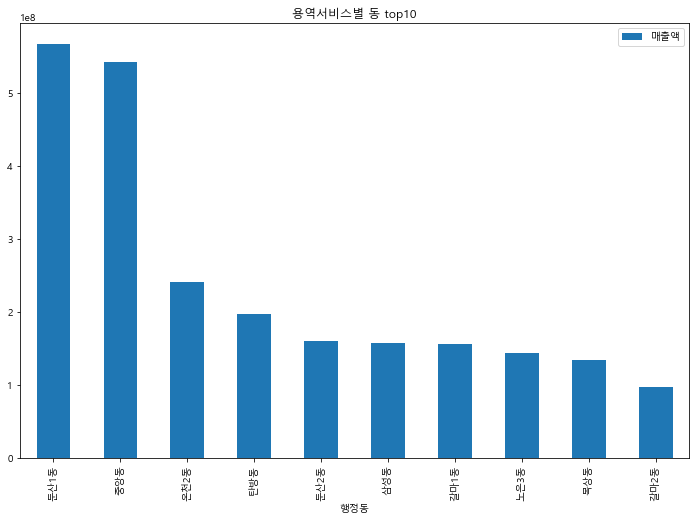

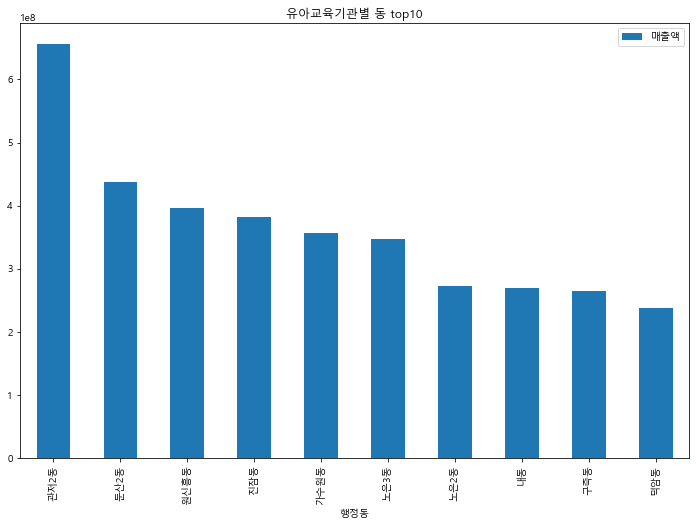

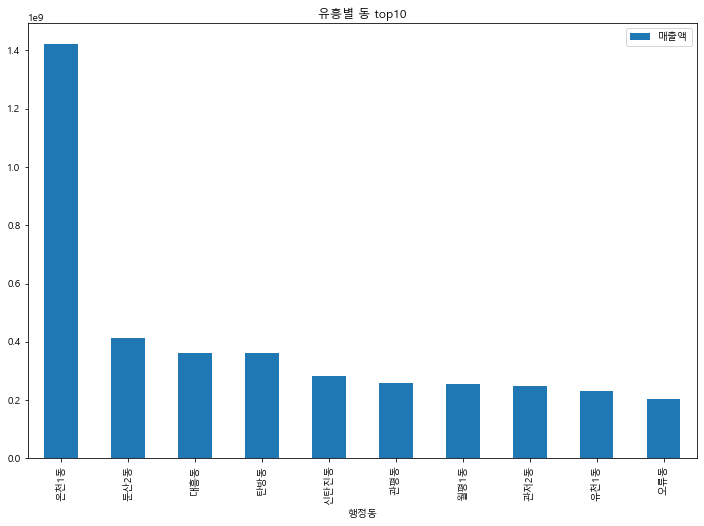

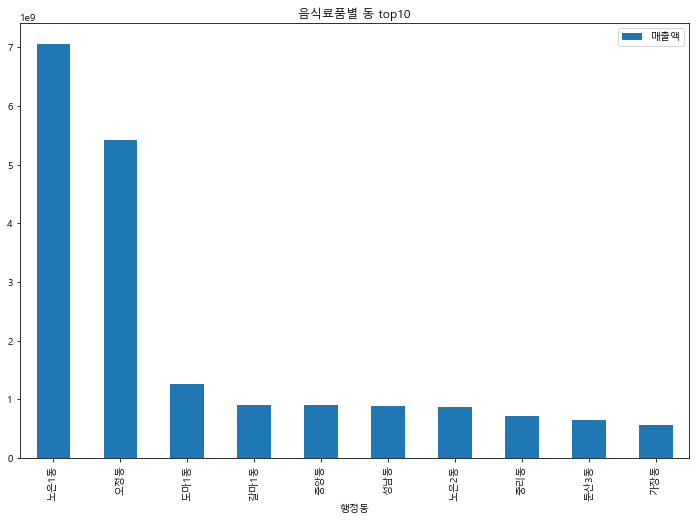

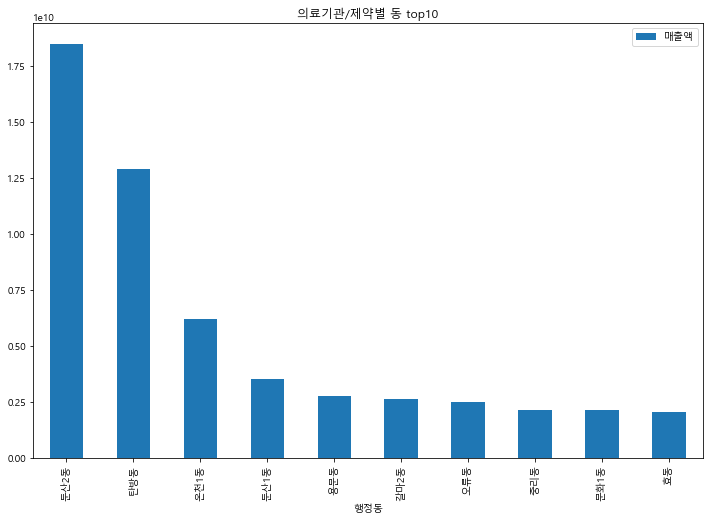

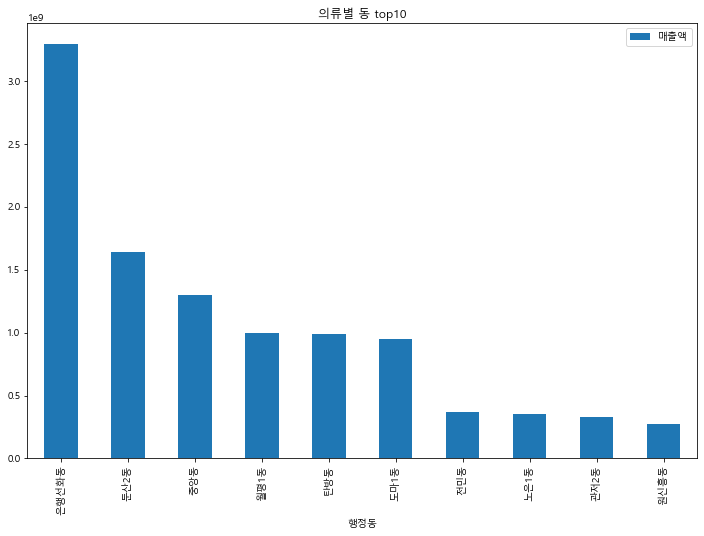

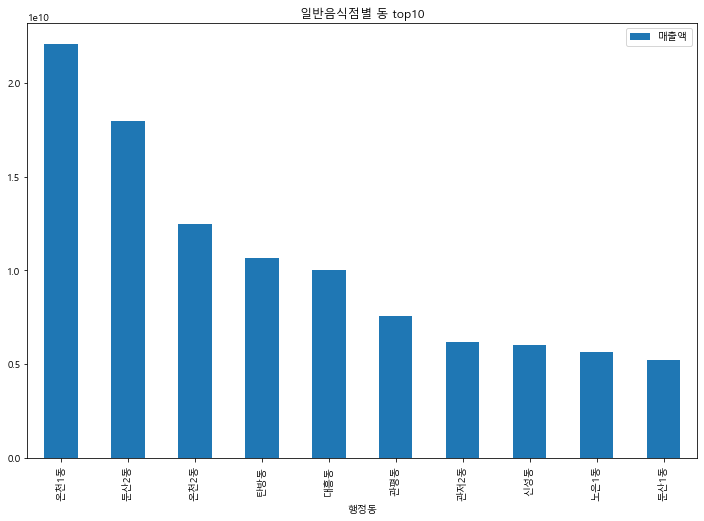

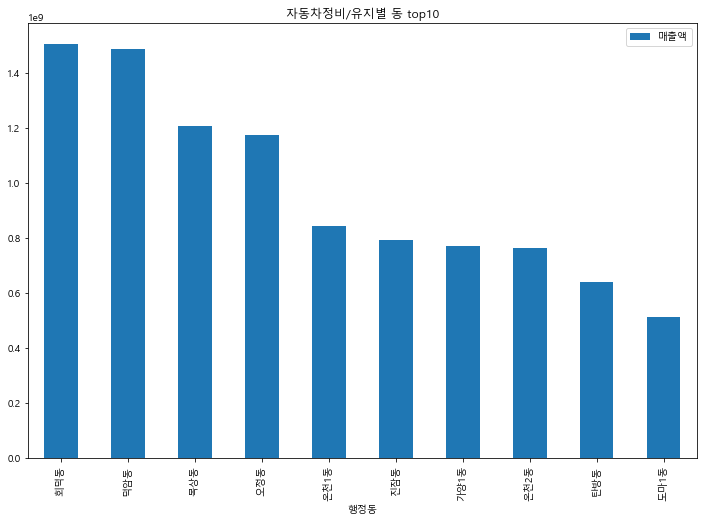

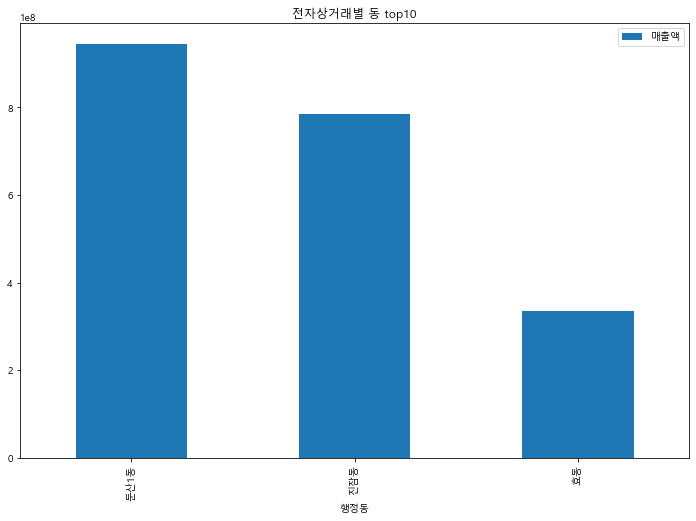

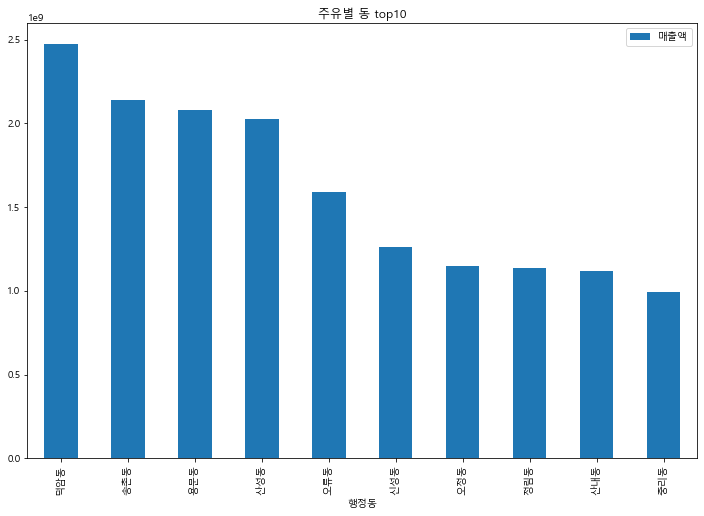

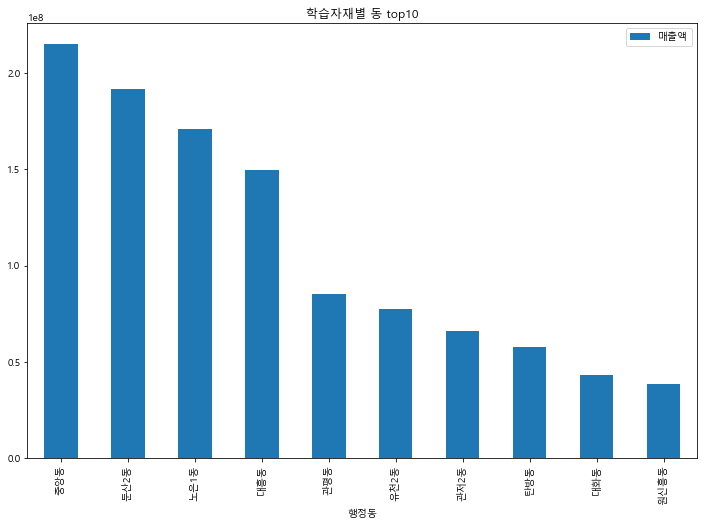

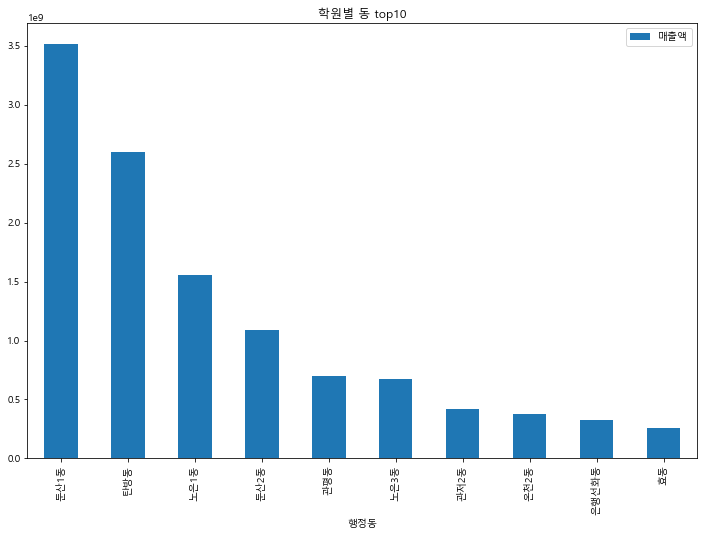

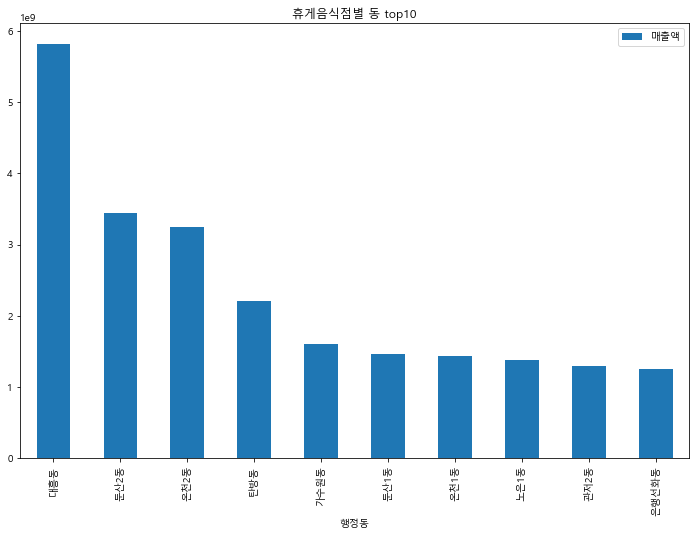

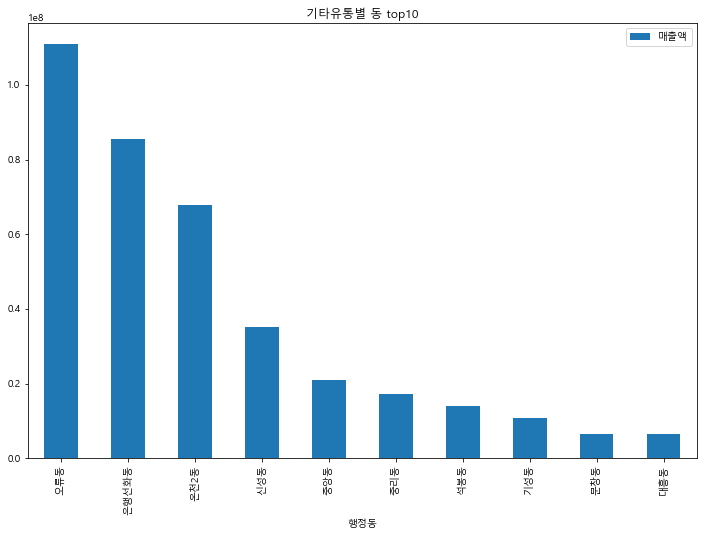

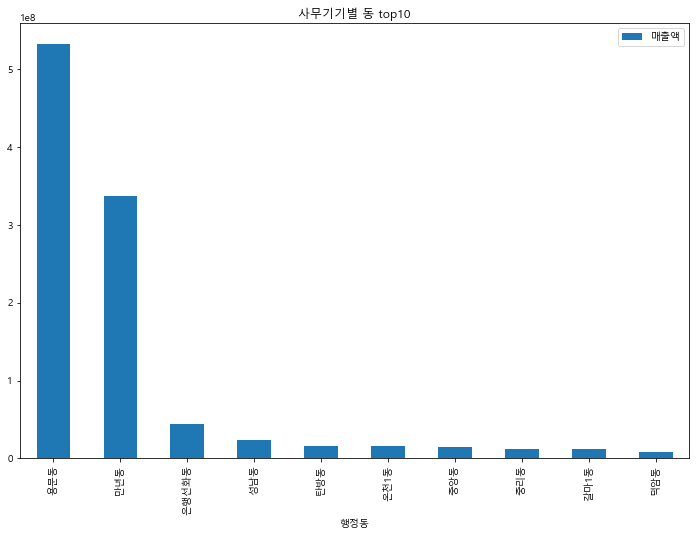

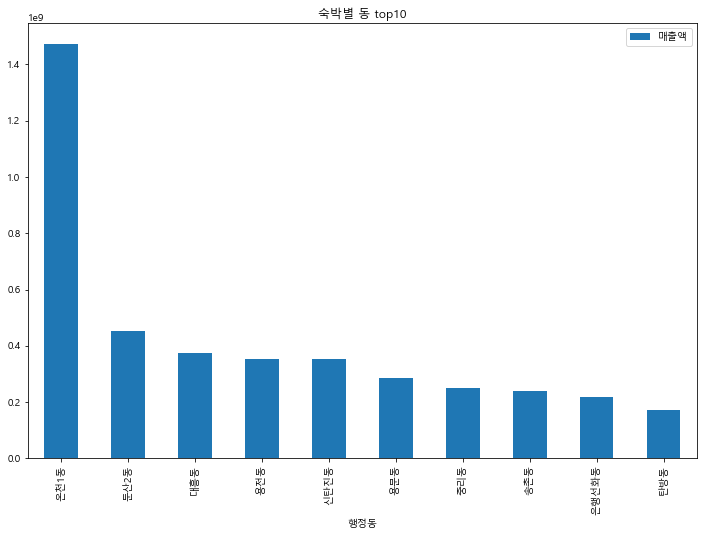

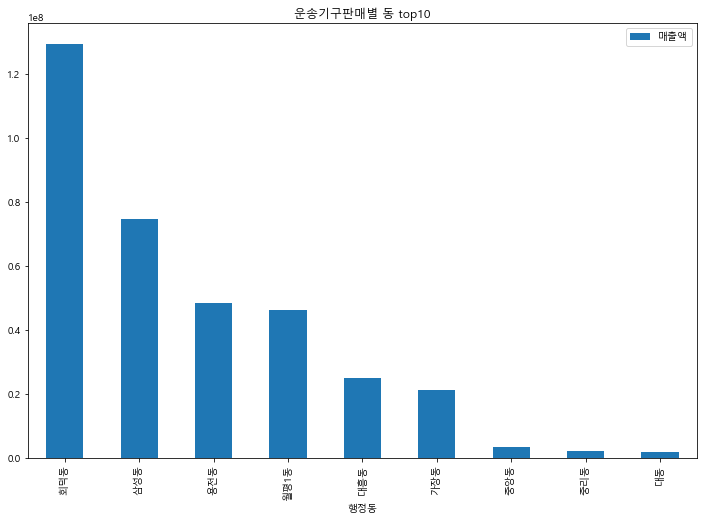

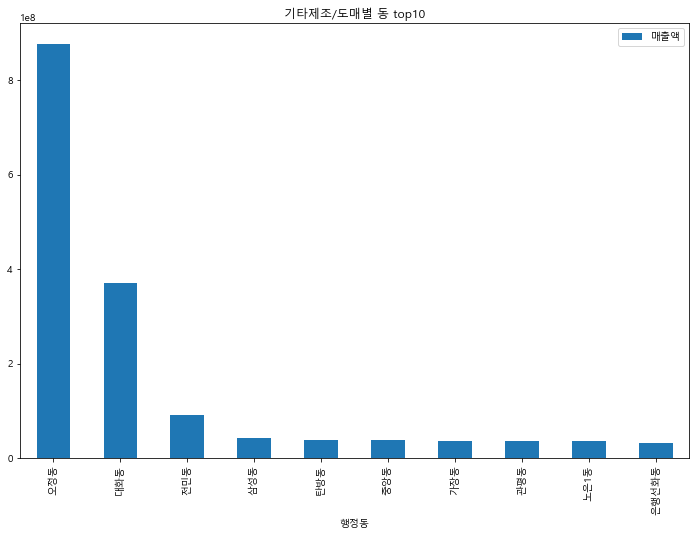

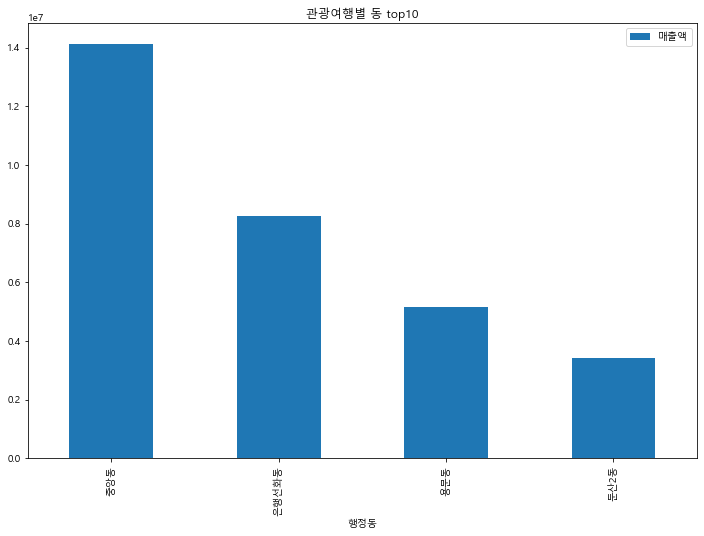

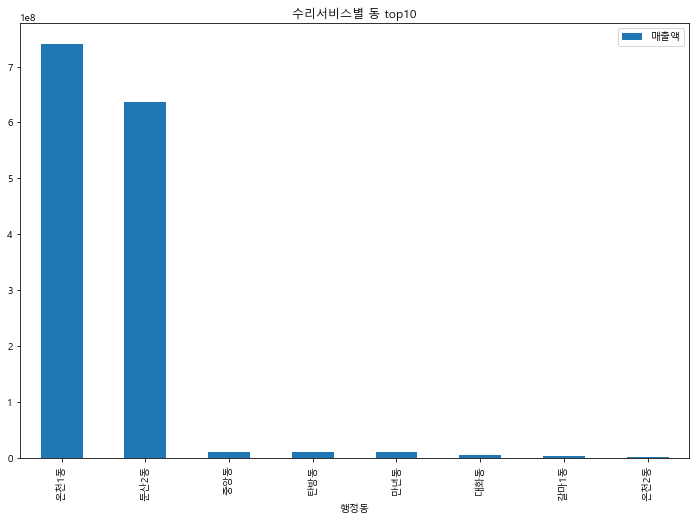

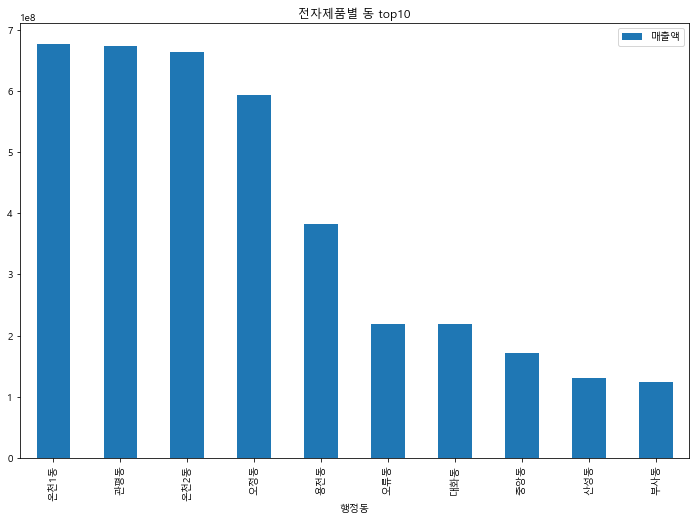

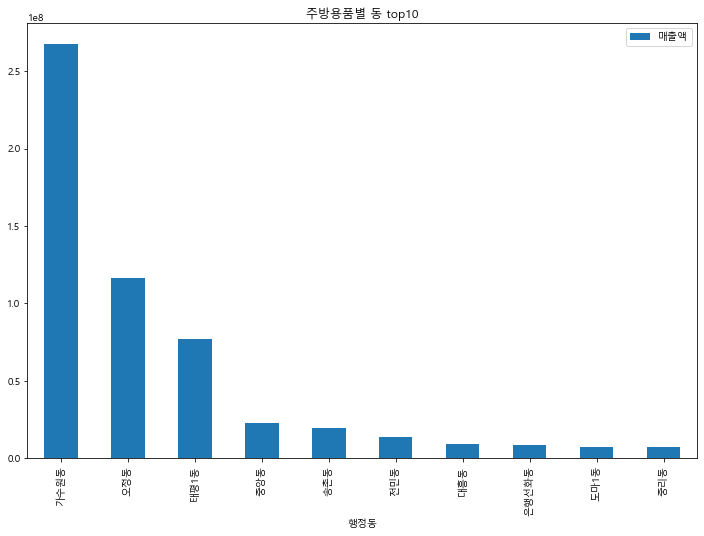

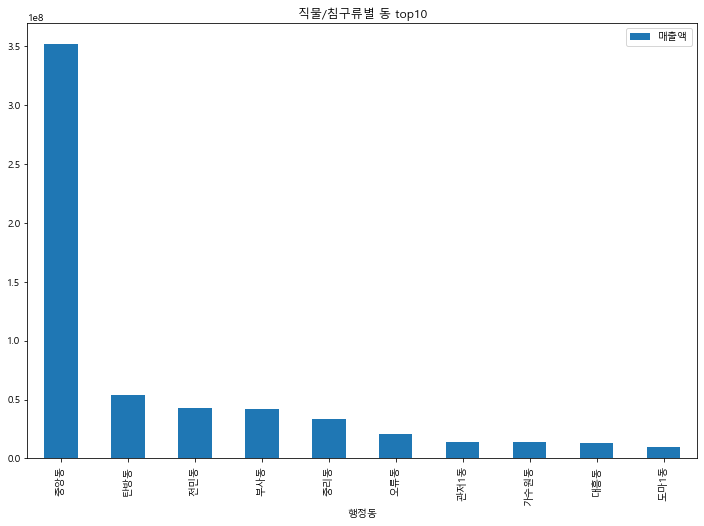

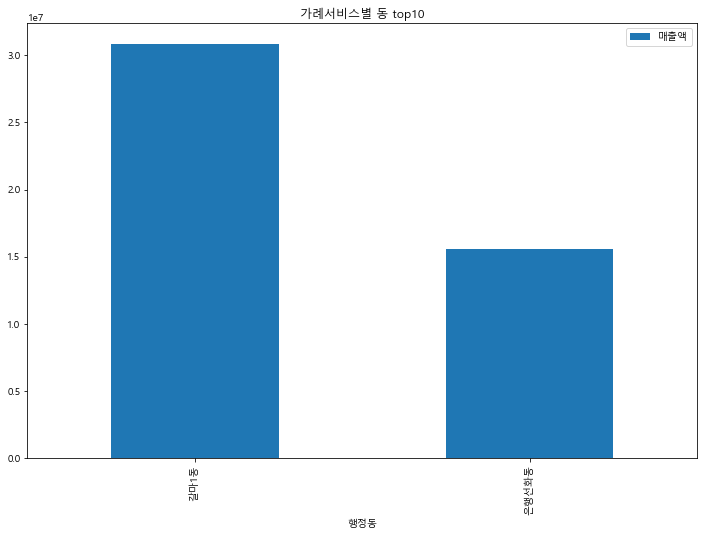

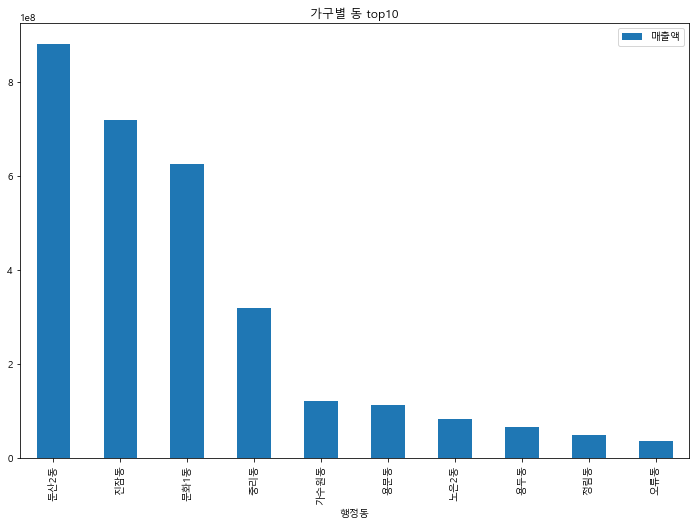

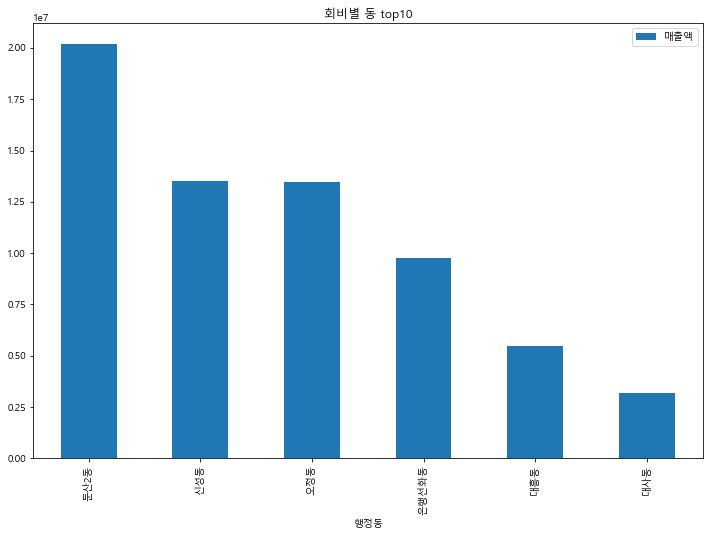

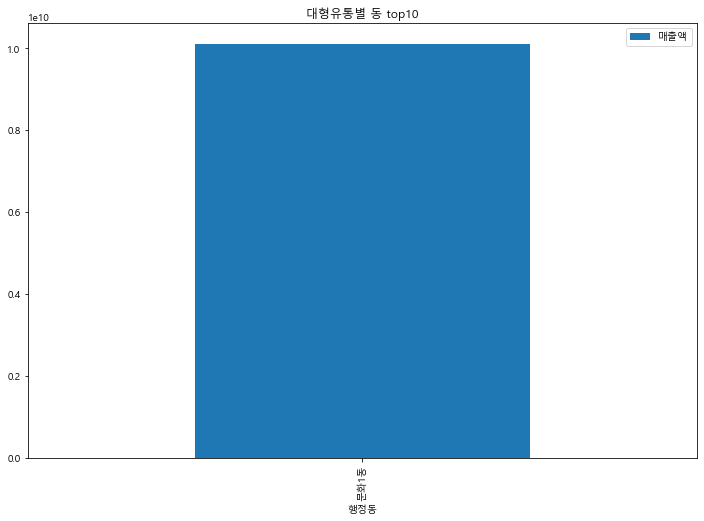

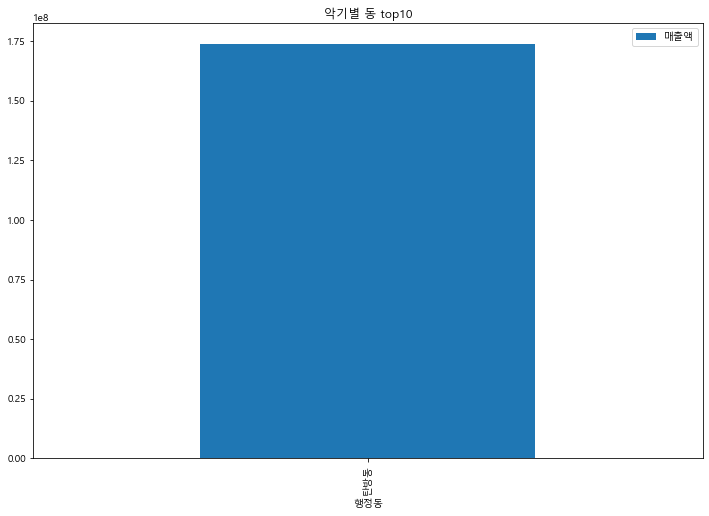

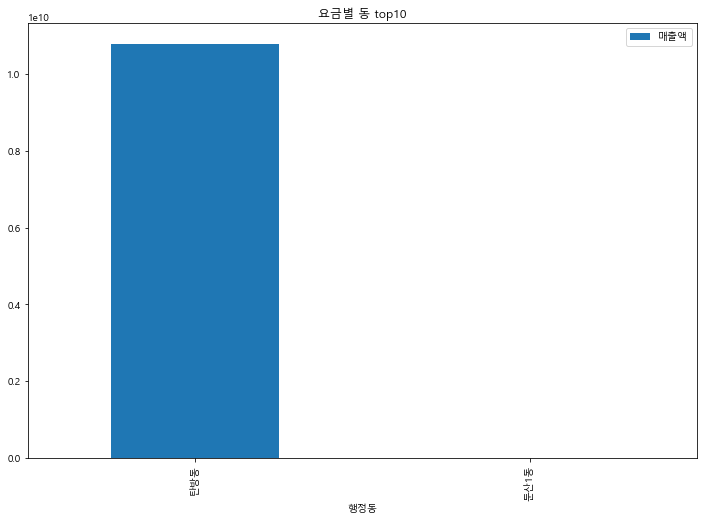

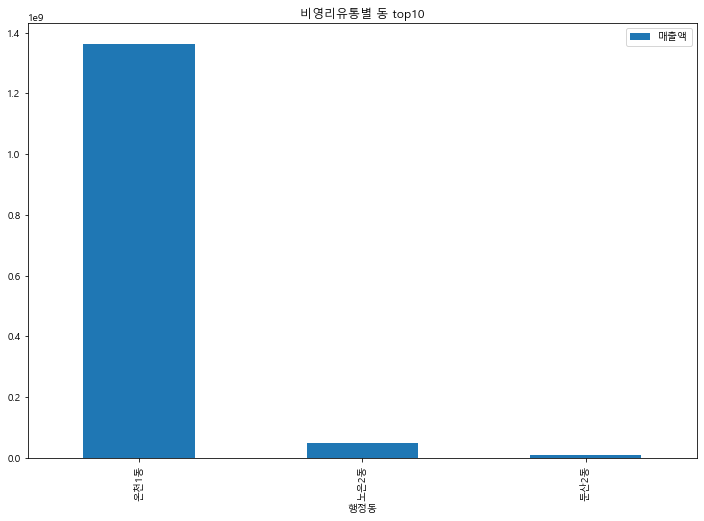

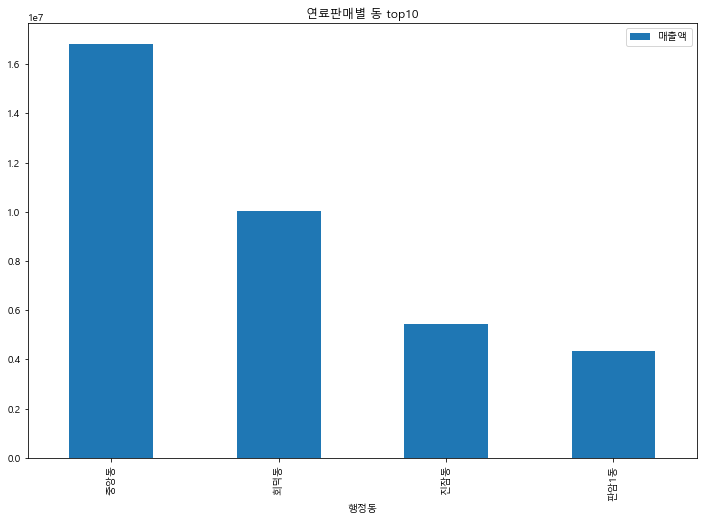

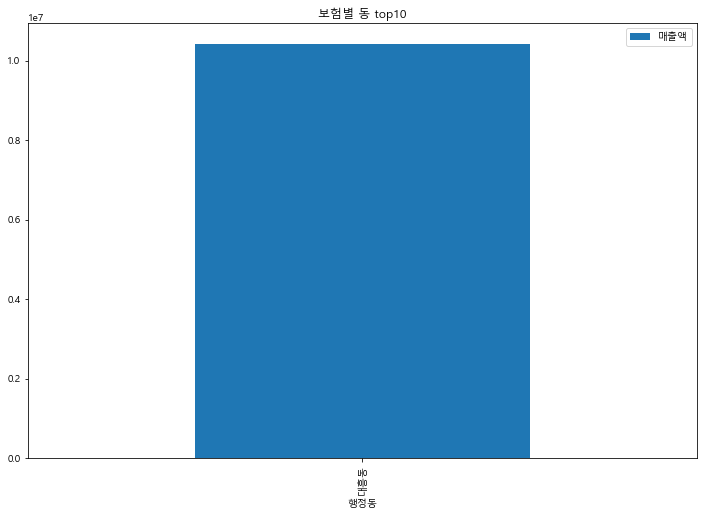

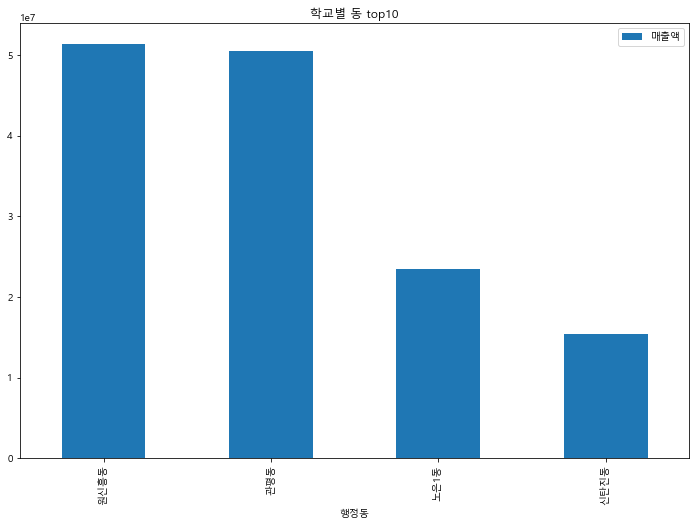

In [212]:
card_plot_classification(card)

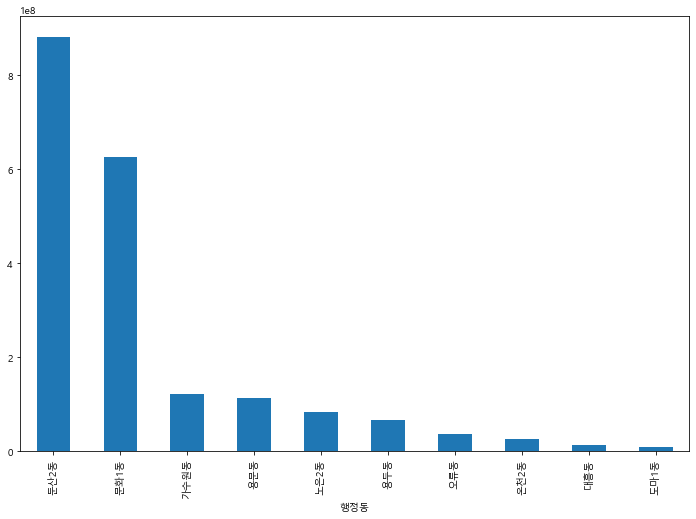

In [184]:
card.loc[card['분류'] == '가구',:].groupby('행정동')['매출액'].mean()[:10].sort_values(ascending = False).plot.bar(figsize=(12,8))

In [405]:
card_pivot=pd.pivot_table(index='읍면동',columns='분류',values='매출액',data=card,aggfunc=['mean']).fillna(0)

In [409]:
new_col

['평균_가구_매출액']

In [ ]:
new_col =[]
for c in card_pivot.columns.levels[1] :
    new_col.append(f'평균_{c}')
card_pivot.columns = new_col
card_pivot.reset_index(inplace = True)

In [431]:
card_pivot.iloc[:,1:] = card_pivot.iloc[:,1:].astype('int64')

## 9 버스 정류장

In [12]:
bus=pd.read_csv('버스정류소.csv',engine = 'python')

In [13]:
bus_1 = bus.iloc[:,1:].groupby('정류장').mean().round(0).astype(int).reset_index()

In [9]:
bus_stop = pd.read_excel('버스승하차.xlsx')

In [38]:
bus_stop = bus_stop.iloc[:,1:]

In [50]:
bus_stop_groupby = bus_stop.groupby('읍면동').mean()/30

In [59]:
bus_stop_groupby = bus_stop_groupby.round(0).astype(int).reset_index()

In [34]:
bus_stop1=pd.read_excel('버스승하차13.xlsx')

In [62]:
bus_stop1 = bus_stop1.iloc[:,1:]

In [64]:
bus_stop1.rename(columns = {'동' :'읍면동'},inplace = True)

In [69]:
bus_stop1_groupby = bus_stop1.groupby('읍면동').mean().round(0).astype(int)

In [70]:
bus_stop1_groupby.reset_index(inplace = True)

In [88]:
total_bus=pd.concat([bus_stop_groupby,bus_stop1_groupby])

In [95]:
total_bus = total_bus.groupby('읍면동').mean().round(0).astype('int64').reset_index()

In [103]:
mapping_dj = mapping_dj.dropna(subset = ['읍면동명']).reset_index()

In [104]:
del mapping_dj['index']

In [107]:
a = ['읍면동명','동리명']

In [109]:
map_dj = mapping_dj[a]

In [113]:
total_bus.rename(columns={'읍면동' : '동리명'},inplace = True)

In [124]:
bus_mapping = pd.merge(total_bus,map_dj,on='동리명')

In [129]:
bus_mapping = bus_mapping.groupby('읍면동명').mean().round(0).astype('int64').reset_index()

In [133]:
bus_mapping.rename(columns={'읍면동명' : '읍면동'},inplace = True)

In [196]:
def sum_bus(data,a) :
    bus_list = []
    for s in data.columns :
        if a in s :
            bus_list.append(s)
    data[a] = data[bus_list].sum(axis =1).round(0).astype('int64')

In [197]:
sum_bus(bus_mapping,'승차')
sum_bus(bus_mapping,'하차')
sum_bus(bus_mapping,'환승')

In [207]:
bus_col = ['읍면동','승차','하차','환승']

## 10 주점

In [21]:
drink = pd.read_csv('행정동별_주점.csv',engine = 'python')

## 11 동별 인구

In [222]:
population=pd.read_excel('2020년 4월말 주민등록현황(구별-동별-연령별).xls')

In [240]:
dong = []
for i in population['읍면동'] :
    dong.append(re.sub(r'\([^)]*\)', '', i))
population['읍면동'] = dong

In [243]:
population['남성비율'] = population['남자_총인구수'] / population['총인구수']
population['여성비율'] = population['여자_총인구수'] / population['총인구수']

In [257]:
young = []
for i in population.columns :
    if '20~24' in i :
        young.append(i)
    elif '25~29' in i :
        young.append(i)
population['20~29세_비율'] = population[young].sum(axis = 1) / population['총인구수']

In [ ]:
population.columns[4].split('_')[1]

In [307]:
old = []
for i in population.columns :
    if i.isalpha() == False  :
        if i.split('_')[1].isalpha() == False :
            if int(re.findall('\d+',i)[0]) >= 65 :
                old.append(i)
population['고령자비율'] = population[old].sum(axis = 1) / population['총인구수']

In [309]:
population_col = ['읍면동','총인구수','남성비율','여성비율','20~29세_비율','고령자비율']

## 12 세대

In [348]:
house = pd.read_csv('대전광역시 공동주택 건립현황.csv',encoding ='cp949')

In [349]:
housing = []
for i in house['상세주소'] :
    housing.append(i.split(' ')[0])

In [350]:
house['동리명'] = housing

In [352]:
house = house.drop(['관할 자치구','상세주소'],axis = 1)

In [355]:
house = house.groupby('동리명').sum().reset_index()

In [363]:
mapdj = ['읍면동명','동리명']

In [369]:
house = pd.merge(mapping_dj[mapdj],house,how='left').fillna(0)

In [371]:
house['세대수'] = house['세대수'].astype(int)

In [377]:
house=pd.DataFrame(house.groupby('읍면동명')['세대수'].mean().astype('int64')).reset_index()

In [380]:
house.rename(columns ={'읍면동명' : '읍면동'},inplace = True)

## 13 타슈

In [137]:
tasu=pd.read_csv('2018타슈현황.csv')

In [138]:
tasu_location=pd.read_excel('타슈위치.xlsx')

In [139]:
tasu_location['스테이션'] = tasu_location['스테이션'].astype('float64')

In [140]:
location = []
for loca in tasu_location['지역']:
    location.append(loca.split(' ')[1])

In [141]:
tasu_location['지역'] = location

In [142]:
tasu.head()

,대여스테이션,대여일시,반납스테이션,반납일시,이동거리,회원구분
0,19.0,2018-01-01 05:18,19.0,2018-01-01 05:27,360.0,2
1,46.0,2018-01-01 05:26,157.0,2018-01-01 06:07,2940.0,2
2,100.0,2018-01-01 05:40,103.0,2018-01-01 05:44,350.0,2
3,157.0,2018-01-01 05:46,152.0,2018-01-01 06:03,1790.0,0
4,41.0,2018-01-01 05:49,187.0,2018-01-01 06:02,1110.0,2


In [52]:
tasu_location.head()

,스테이션,장소,지역
0,1.0,무역전시관입구(택시승강장),도룡동
1,2.0,대전컨벤션센터,도룡동
2,3.0,한밭수목원1,만년동
3,4.0,초원아파트(104동 버스정류장),만년동
4,5.0,둔산대공원 입구(버스정류장),둔산2동


In [143]:
tasu=pd.merge(tasu,tasu_location[['스테이션','지역']],left_on='대여스테이션',right_on='스테이션')

In [144]:
tasu=pd.merge(tasu,tasu_location[['스테이션','지역']],left_on='반납스테이션',right_on = '스테이션')

In [145]:
del tasu['대여스테이션']
del tasu['반납스테이션']

In [146]:
del tasu['스테이션_x']
del tasu['스테이션_y']

In [147]:
tasu.rename(columns={'지역_x' : '대여스테이션', '지역_y' : '반납스테이션'},inplace = True)

In [148]:
tasu = tasu.sort_values(by = '대여일시').reset_index()

In [149]:
del tasu['index']

In [150]:
def time_extraction(data,col,new_col) :
    time_list = []
    for t in data[col] :
        time_list.append(t[11:13])
    data[new_col] =time_list
    return data

In [151]:
tasu=time_extraction(tasu,'대여일시','대여시간')

In [152]:
tasu = time_extraction(tasu,'반납일시','반납시간')

In [153]:
tasu[['대여시간','반납시간']] = tasu[['대여시간','반납시간']].astype('int64')

In [154]:
del tasu['대여일시']
del tasu['반납일시']
del tasu['이동거리']
del tasu['회원구분']

In [157]:
def night_extraction(data,col) :
    call_time = []
    time = []
    for c in data[col].unique():
        if not 5 < c < 23 :
            call_time.append(c)
    for t in call_time :
        time.extend(list(data.index[data[col] == t]))
    data = data.iloc[time,:]
    data.reset_index(inplace = True)
    del data['index']
    return data

In [161]:
night_tasu = night_extraction(tasu,'대여시간')

In [176]:
night_tasu_rent=pd.DataFrame(night_tasu.groupby('대여스테이션')['대여시간'].count()).reset_index()

In [178]:
night_tasu_return = pd.DataFrame(night_tasu.groupby('반납스테이션')['대여시간'].count()).reset_index()

In [182]:
night_tasu_rent.rename(columns = {'대여스테이션' : '동리명','대여시간' : '밤_타슈대여'},inplace = True)

In [185]:
night_tasu_return.rename(columns={'반납스테이션' : '동리명','대여시간' : '밤_타슈반납'},inplace = True)

In [189]:
total_tasu = pd.merge(night_tasu_rent,night_tasu_return,on='동리명',how='outer').fillna(0)

In [193]:
total_tasu['밤_타슈반납'] = total_tasu['밤_타슈반납'].astype('int64')

### 낮

In [ ]:
def day_extraction(data,col) :
    call_time = []
    time = []
    for c in data[col].unique():
        if  5 < c < 23 :
            call_time.append(c)
    for t in call_time :
        time.extend(list(data.index[data[col] == t]))
    data = data.iloc[time,:]
    data.reset_index(inplace = True)
    del data['index']
    return data
day_tasu = day_extraction(tasu,'대여시간')

In [197]:
day_tasu_rent = pd.DataFrame(day_tasu.groupby('대여스테이션')['대여시간'].count()).reset_index()
day_tasu_return = pd.DataFrame(day_tasu.groupby('반납스테이션')['대여시간'].count()).reset_index()

In [200]:
day_tasu_rent.rename(columns = {'대여스테이션' : '동리명','대여시간' : '낮_타슈대여'},inplace = True)
day_tasu_return.rename(columns={'반납스테이션' : '동리명','대여시간' : '낮_타슈반납'},inplace = True)

In [201]:
total_tasu_day = pd.merge(day_tasu_rent,day_tasu_return,on='동리명',how='outer').fillna(0)

In [206]:
total_tasu = pd.merge(total_tasu,total_tasu_day,on='동리명')

In [221]:
total_tasu.to_csv('타슈진행.csv',encoding = 'cp949')

In [25]:
total_tasu=pd.read_csv('타슈진행.csv',encoding='cp949')

In [26]:
del total_tasu['Unnamed: 0']

In [32]:
total_tasu=pd.merge(total_tasu,mapping_dj,how='right').fillna(0)

In [40]:
total_tasu = total_tasu.groupby('읍면동명')[total_tasu.columns[1:5]].mean().round(0).astype('int64').reset_index()

In [46]:
total_tasu.rename(columns={'읍면동명' : '읍면동'},inplace = True)

## 14. 고소득

In [165]:
price=pd.read_csv('공시지가_고소득.csv')

In [168]:
price.rename(columns={'name' : '읍면동'},inplace = True)

In [170]:
price.rename(columns={'price' : '공시지가'},inplace = True)

In [172]:
price = price[['읍면동','고소득','공시지가']]

## 대전 통합

In [199]:
total=pd.read_csv('최종data.csv',encoding = 'cp949')

In [200]:
del total['버스승하차']

In [208]:
total = pd.merge(total,bus_mapping[bus_col],on='읍면동')
total = pd.merge(total,population[population_col],on='읍면동')
total = pd.merge(total,house,on='읍면동')
total = pd.merge(total,card_pivot,on='읍면동')
total = pd.merge(total,total_traffic,on='읍면동')
total = pd.merge(total,total_taxi,on='읍면동')
total = pd.merge(total,total_tasu,on='읍면동')
total = pd.merge(total,school,on='읍면동')

In [312]:
feat_list= []
for feature in total.columns :
    if total[feature].dtype == 'int64' :
        if total[feature].value_counts().shape[0] == 2 :
            feat_list.append(feature)
            print(total[feature].value_counts())

In [162]:
total = total.drop(feat_list,axis = 1)

In [174]:
total=pd.merge(total,price,on='읍면동')

In [335]:
percent_list = []
for feature in total.columns :
    if total[feature].dtype == 'int64' :
        if 0 in total[feature].unique() :
            if total[feature].value_counts(normalize = True,sort=False)[0] > 0.75 :
                percent_list.append(feature)

In [342]:
percent_list.remove('대학교')

In [346]:
total = total.drop(percent_list,axis = 1)

In [5]:
total['승하차'] = total['승차'] + total['하차']

In [6]:
del total['승차']
del total['하차']

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(total['시군구'])
total['시군구_label'] = list(le.transform(total['시군구']))

In [9]:
total.to_csv('대전.csv',encoding = 'cp949')

In [70]:
train = total[day_col]

In [77]:
test = total[night_col]

In [72]:
address = total['읍면동']

In [87]:
train.rename(columns={'주간유동인구' : '유동인구',"주간매출액" : '매출액','고령평균주간유동인구' :'고령평균유동인구',
                     '20대평균주간유동인구' : '20대평균유동인구','주간콜택시' :'콜택시','낮_타슈대여':'타슈대여',
                     '낮_타슈반납' :'타슈반납'},inplace = True)

In [89]:
test.rename(columns={'야간유동인구' : '유동인구',"야간매출액" : '매출액','고령평균야간유동인구' :'고령평균유동인구',
                     '20대평균야간유동인구' : '20대평균유동인구','야간콜택시' :'콜택시','밤_타슈대여':'타슈대여',
                     '밤_타슈반납' :'타슈반납'},inplace = True)

In [ ]:
train.to_csv('train_1.csv',encoding = 'cp949')
test.to_csv('test_1.csv',encoding = 'cp949')

In [109]:
bus = train['승하차']

In [110]:
del train['승하차']

In [2]:
total=pd.read_csv('대전.csv',encoding = 'cp949')
train=pd.read_csv('train_1.csv',encoding = 'cp949')
test = pd.read_csv('test_1.csv',encoding = 'cp949')

In [3]:
del train['Unnamed: 0']
del total['Unnamed: 0']
del test['Unnamed: 0']
y_train = train['승하차']
del train['승하차']

In [19]:
train['읍면동'] = total['읍면동']

In [21]:
train.to_csv('train_1.csv',encoding = 'cp949')

## Feature Engineering

In [353]:
train = pd.read_csv('train_1.csv',encoding = 'cp949')
test = pd.read_csv('test_1.csv',encoding = 'cp949')

### 카드 데이터 feature 비율로 변환


In [354]:
mean_col = []
new_feats = []
for col in train.columns :
    if col.startswith('평균'):
        mean_col.append(col)
for c in mean_col :
    new_col_name = '{}_비율'.format(c)
    train[new_col_name] = train[c] / train[mean_col].sum(axis = 1)

In [355]:
train_ver1 = train.drop(mean_col,axis = 1)
test_ver1 = test.drop(mean_col,axis = 1)

In [356]:
train_ver1 = train.drop(mean_col,axis = 1)
test_ver1 = test.drop(mean_col,axis = 1)

In [357]:
train = train.drop(new_feats,axis = 1)
test = test.drop(new_feats,axis = 1)

### 공부

In [358]:
study = ['도서관','대학교','고등학교']
puberty = ['유치원','초등학교','중학교']

In [359]:
train_ver1['study'] = train_ver1[study].sum(axis = 1)
train['study'] = train[study].sum(axis = 1)
test_ver1['study'] = test_ver1[study].sum(axis = 1)
test['study'] = test[study].sum(axis = 1)

train_ver1['puberty'] = train_ver1[puberty].sum(axis = 1)
train['puberty'] = train[puberty].sum(axis = 1)
test_ver1['puberty'] = test_ver1[puberty].sum(axis = 1)
test['puberty'] = test[puberty].sum(axis = 1)

In [360]:
train = train.drop(study,axis = 1)
train_ver1 = train_ver1.drop(study,axis = 1)
test = test.drop(study,axis = 1)
test_ver1 = test_ver1.drop(study,axis = 1)

In [361]:
train = train.drop(puberty,axis = 1)
train_ver1 = train_ver1.drop(puberty,axis = 1)
test= test.drop(puberty,axis = 1)
test_ver1 = test_ver1.drop(puberty,axis = 1)

### 비율로 바꾸기

In [362]:
def percent_day_night(train,test,feature) :
    new_col_name = '{}_비율'.format(feature)
    train[new_col_name] = (train[feature] / (train[feature] + test[feature])).round(2)
    test[new_col_name] = (test[feature] / (train[feature] + test[feature])).round(2)

In [363]:
percent_day_night(train_ver1,test_ver1,'콜택시')

In [364]:
train_ver1['콜택시_비율'] =train_ver1['콜택시_비율'].fillna(0)
test_ver1['콜택시_비율'] = test_ver1['콜택시_비율'].fillna(0)

In [365]:
percent_day_night(train_ver1,test_ver1,'타슈대여')
percent_day_night(train_ver1,test_ver1,'타슈반납')

In [366]:
train_ver2 =train_ver1.drop(['타슈대여','타슈반납'],axis = 1)
test_ver2 = test_ver1.drop(['타슈대여','타슈반납'],axis = 1)

In [367]:
train_ver2['타슈대여_비율'] = train_ver2['타슈대여_비율'].fillna(0)
test_ver2['타슈반납_비율'] = test_ver2['타슈반납_비율'].fillna(0)

In [386]:
train_ver2['타슈반납_비율'] = train_ver2['타슈반납_비율'].fillna(0)
test_ver2['타슈대여_비율'] = test_ver2['타슈대여_비율'].fillna(0)

- ver2 = 낮밤 비율

In [368]:
train_ver1.drop(['타슈대여_비율','타슈반납_비율'],axis = 1,inplace = True)
test_ver1.drop(['타슈대여_비율','타슈반납_비율'],axis = 1,inplace = True)

In [369]:
tasu = ['타슈반납','타슈대여']
train_ver1['타슈반납비율'] =  (train_ver1['타슈반납']/ train_ver1[tasu].sum(axis = 1)).round(2).fillna(0)
test_ver1['타슈반납비율'] =  (test_ver1['타슈반납']/ test_ver1[tasu].sum(axis = 1)).round(2).fillna(0)

train_ver1['타슈대여비율'] =  (train_ver1['타슈대여']/ train_ver1[tasu].sum(axis = 1)).round(2).fillna(0)
test_ver1['타슈대여비율'] =  (test_ver1['타슈대여']/ test_ver1[tasu].sum(axis = 1)).round(2).fillna(0)

In [370]:
train_ver1.drop(tasu,axis = 1, inplace = True)
test_ver1.drop(tasu,axis = 1,inplace = True)

In [371]:
percent_day_night(train_ver1,test_ver1,'유동인구')
percent_day_night(train_ver1,test_ver1,'고령평균유동인구')
percent_day_night(train_ver1,test_ver1,'20대평균유동인구')
percent_day_night(train_ver1,test_ver1,'매출액')

percent_day_night(train_ver2,test_ver2,'유동인구')
percent_day_night(train_ver2,test_ver2,'고령평균유동인구')
percent_day_night(train_ver2,test_ver2,'20대평균유동인구')
percent_day_night(train_ver2,test_ver2,'매출액')

In [372]:
del test_ver2['Unnamed: 0']

In [ ]:
def visualization_dj(data,group,want,num) :
    viz = pd.DataFrame(data.groupby(group)[want].mean().round(num)).reset_index()
    return sns.barplot(data = viz, x=group,y = want,palette='magma').set_title('구별 평균 {}'.format(want))

In [32]:
transfer=pd.DataFrame(dj.groupby('시군구')['환승'].mean().round(0).sort_values(ascending = False)).reset_index()

Text(0.5, 1.0, '구별 평균 환승')

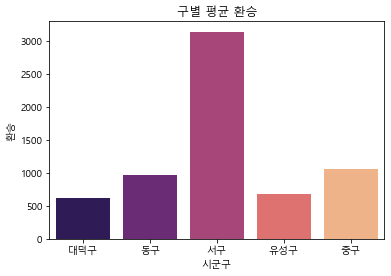

In [17]:
visualization_dj(dj,'시군구','환승',0)

Text(0.5, 1.0, '구별 평균 승하차')

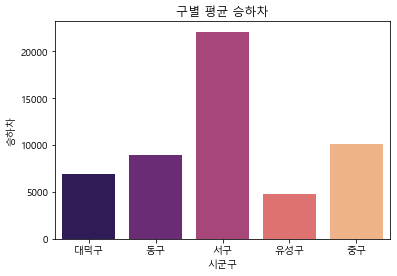

In [18]:
visualization_dj(dj,'시군구','승하차',0)

Text(0.5, 1.0, '구별 평균 주간콜택시')

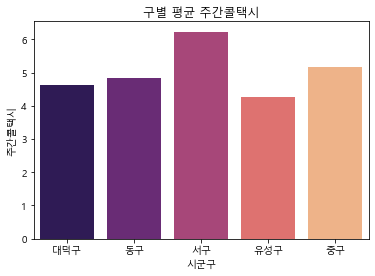

In [19]:
visualization_dj(dj,'시군구','주간콜택시',2)

Text(0.5, 1.0, '구별 평균 야간콜택시')

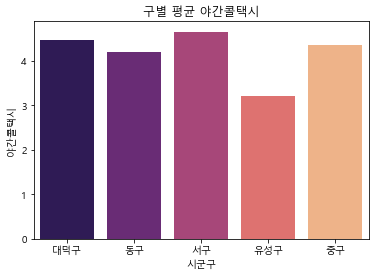

In [20]:
visualization_dj(dj,'시군구','야간콜택시',2)